# PARTIE (II)

## 7. Détection d'Anomalies : Méthode Statistique (Z-score)

### 7.1 Présentation de la méthode

Le **Z-score** (ou score standard) mesure l'écart d'une observation par rapport à la moyenne, exprimé en nombre d'écarts-types :

$$Z = \frac{X - \mu}{\sigma}$$

Une observation est considérée comme **anomalie** si son Z-score dépasse un seuil :
- |Z| > 2 : Anomalie modérée (~5% des données)
- |Z| > 3 : Anomalie extrême (~0.3% des données)

### 7.2 Avantages et limites

| Avantages | Limites |
|-----------|---------|
| ✅ Simple et interprétable | ❌ Assume une distribution normale |
| ✅ Rapide à calculer | ❌ Sensible aux outliers existants |
| ✅ Seuil paramétrable | ❌ Ne capture pas les patterns complexes |
| ✅ Baseline de référence | ❌ Univarié (1 variable à la fois) |

### 7.3 Application par horizon

| Horizon | Variable cible | Justification |
|---------|---------------|---------------|
| Court terme | STL_Residual | Écarts ponctuels à la tendance/saisonnalité |
| Moyen terme | STL_Residual | Même variable, seuil potentiellement différent |
| Long terme | TrendAcceleration | Changements de régime climatique |

📊 DÉTECTION D'ANOMALIES PAR Z-SCORE

📊 TESTS DE NORMALITÉ (Shapiro-Wilk) :



,Horizon,Variable,P-value,Distribution
0,Court terme,STL_Residual,0.0000,⚠️ Non normale
1,Moyen terme,STL_Residual,0.0000,⚠️ Non normale
2,Long terme,TrendAcceleration,0.2067,✅ Normale



💡 Interprétation : Le Z-score assume une distribution normale.
   Pour les distributions non normales, interpréter les résultats avec prudence.

📋 ANOMALIES DÉTECTÉES PAR HORIZON ET SEUIL



,Horizon,Variable,Seuil,Anomalies,%,Chaudes,Froides
0,Court terme,STL_Residual,|Z|>2,146,7.3%,72,74
1,Court terme,STL_Residual,|Z|>2.5,90,4.5%,46,44
2,Court terme,STL_Residual,|Z|>3,55,2.8%,27,28
3,Moyen terme,STL_Residual,|Z|>2,146,7.3%,72,74
4,Moyen terme,STL_Residual,|Z|>2.5,90,4.5%,46,44
5,Moyen terme,STL_Residual,|Z|>3,55,2.8%,27,28
6,Long terme,TrendAcceleration,|Z|>2,94,4.8%,43,51
7,Long terme,TrendAcceleration,|Z|>2.5,18,0.9%,10,8
8,Long terme,TrendAcceleration,|Z|>3,3,0.2%,0,3


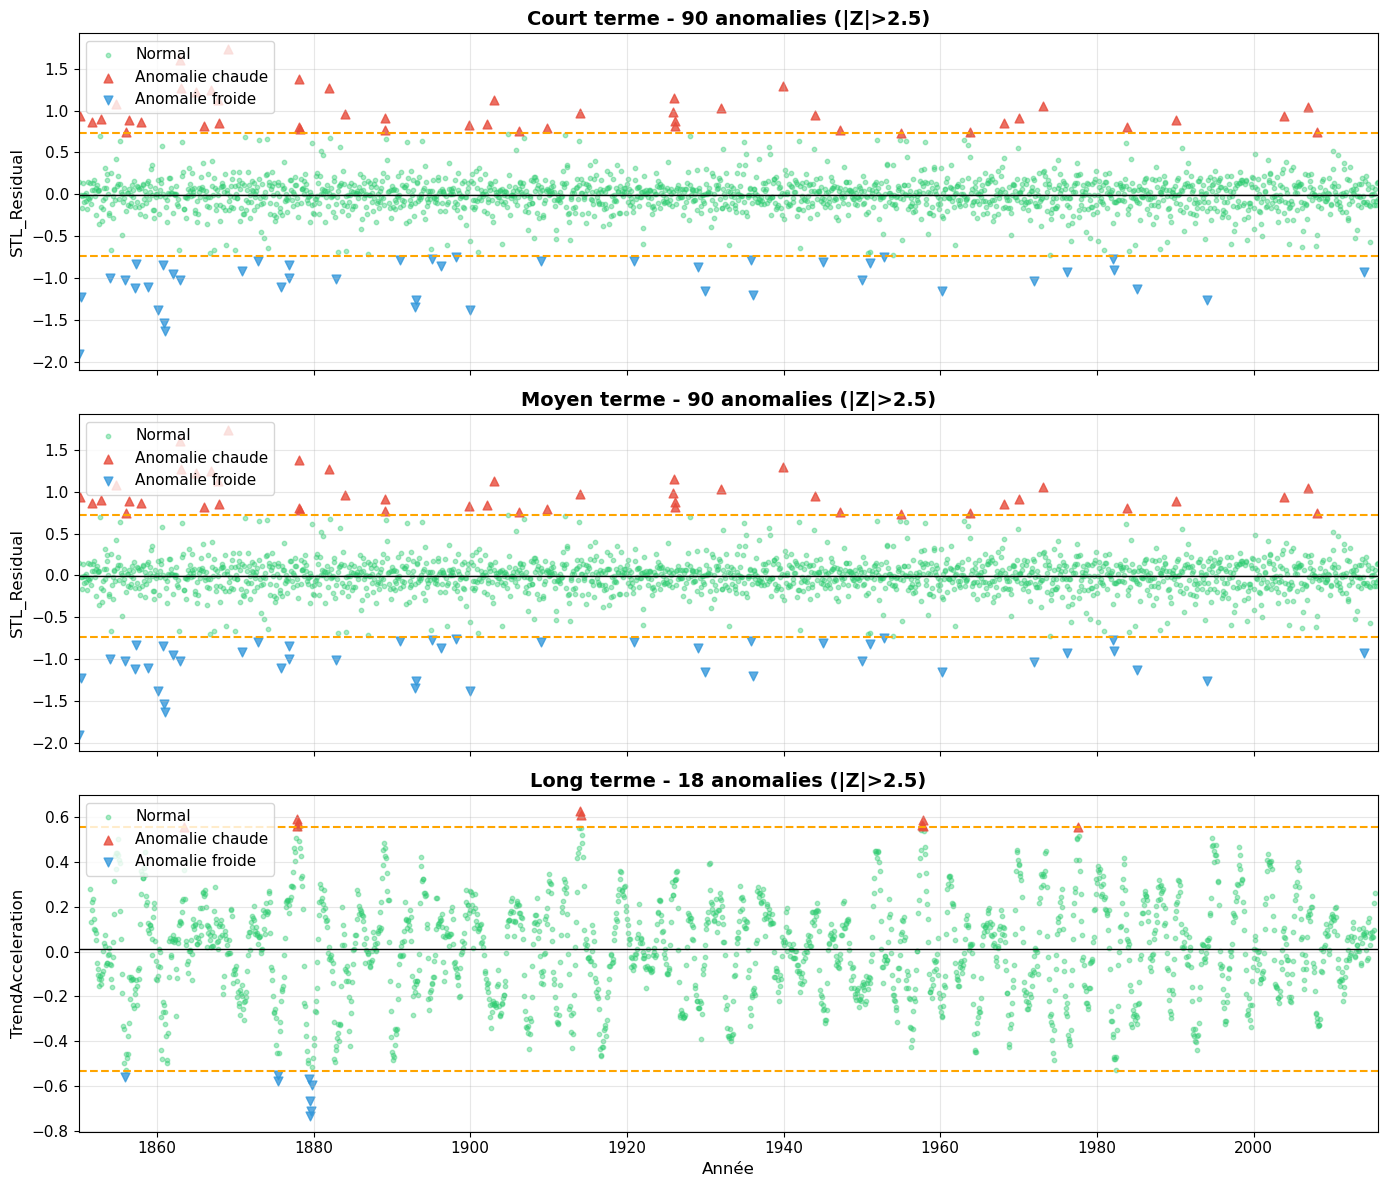

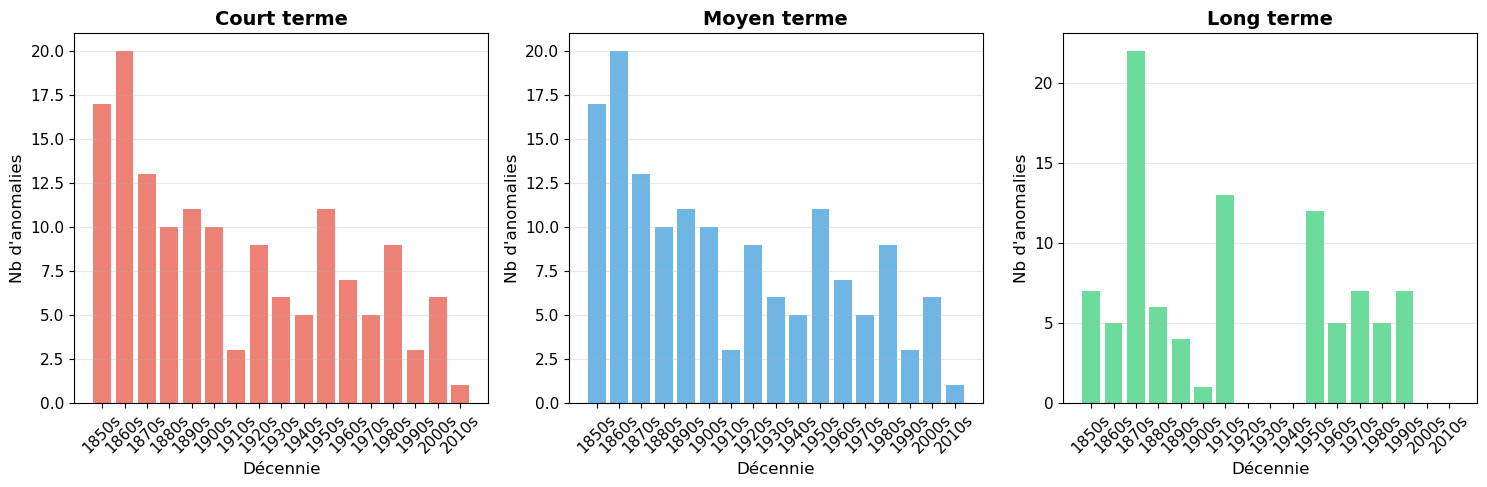


💾 RÉSULTATS STOCKÉS
   Anomaly_ZScore_CT : 90 anomalies
   Anomaly_ZScore_MT : 90 anomalies
   Anomaly_ZScore_LT : 18 anomalies


In [13]:
# ============================================================
# 7. DÉTECTION D'ANOMALIES PAR Z-SCORE
# ============================================================

from scipy import stats

print("="*70)
print("📊 DÉTECTION D'ANOMALIES PAR Z-SCORE")
print("="*70)

# --- 1. CONFIGURATION PAR HORIZON ---
zscore_config = {
    'Court terme': {'variable': 'STL_Residual', 'color': COLORS['temperature']},
    'Moyen terme': {'variable': 'STL_Residual', 'color': COLORS['trend']},
    'Long terme': {'variable': 'TrendAcceleration', 'color': COLORS['normal']}
}

thresholds = [2, 2.5, 3]

# --- 2. FONCTION DE DÉTECTION ---
def detect_anomalies_zscore(series, threshold=2):
    """Détecte les anomalies par Z-score."""
    series_clean = series.dropna()
    z_scores = stats.zscore(series_clean)
    z_scores_series = pd.Series(z_scores, index=series_clean.index)
    anomalies_mask = np.abs(z_scores_series) > threshold
    return anomalies_mask, z_scores_series

# --- 3. TESTS DE NORMALITÉ ---
print("\n📊 TESTS DE NORMALITÉ (Shapiro-Wilk) :\n")

normality_results = []
for horizon, config in zscore_config.items():
    series = df[config['variable']].dropna()
    sample = series.sample(min(500, len(series)), random_state=42)
    _, pval = stats.shapiro(sample)
    
    is_normal = pval >= 0.05
    status = "✅ Normale" if is_normal else "⚠️ Non normale"
    
    normality_results.append({
        'Horizon': horizon,
        'Variable': config['variable'],
        'P-value': f"{pval:.4f}",
        'Distribution': status
    })

normality_df = pd.DataFrame(normality_results)
display(normality_df)

print("\n💡 Interprétation : Le Z-score assume une distribution normale.")
print("   Pour les distributions non normales, interpréter les résultats avec prudence.")

# --- 4. APPLICATION SUR CHAQUE HORIZON ---
results_zscore = {}

for horizon, config in zscore_config.items():
    variable = config['variable']
    series = df[variable].dropna()
    
    horizon_results = {}
    for thresh in thresholds:
        anomalies_mask, z_scores = detect_anomalies_zscore(series, threshold=thresh)
        n_pos = (z_scores[anomalies_mask] > 0).sum()
        n_neg = (z_scores[anomalies_mask] < 0).sum()
        
        horizon_results[thresh] = {
            'mask': anomalies_mask,
            'z_scores': z_scores,
            'n_anomalies': anomalies_mask.sum(),
            'pct': anomalies_mask.sum() / len(series) * 100,
            'n_pos': n_pos,
            'n_neg': n_neg
        }
    
    results_zscore[horizon] = {'variable': variable, 'series': series, 'results': horizon_results}

# --- 5. TABLEAU RÉCAPITULATIF ---
print("\n" + "="*70)
print("📋 ANOMALIES DÉTECTÉES PAR HORIZON ET SEUIL")
print("="*70 + "\n")

recap_data = []
for horizon, data in results_zscore.items():
    for thresh, res in data['results'].items():
        recap_data.append({
            'Horizon': horizon,
            'Variable': data['variable'],
            'Seuil': f'|Z|>{thresh}',
            'Anomalies': res['n_anomalies'],
            '%': f"{res['pct']:.1f}%",
            'Chaudes': res['n_pos'],
            'Froides': res['n_neg']
        })

recap_df = pd.DataFrame(recap_data)
display(recap_df)

# --- 6. VISUALISATION PAR HORIZON ---
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
threshold_display = 2.5

for idx, (horizon, data) in enumerate(results_zscore.items()):
    ax = axes[idx]
    series = data['series']
    z_scores = data['results'][threshold_display]['z_scores']
    anomalies_mask = data['results'][threshold_display]['mask']
    
    # Points normaux
    normal_mask = ~anomalies_mask
    ax.scatter(series.index[normal_mask], series[normal_mask], 
               c=COLORS['normal'], alpha=0.4, s=10, label='Normal')
    
    # Anomalies positives et négatives
    pos_mask = anomalies_mask & (z_scores > 0)
    neg_mask = anomalies_mask & (z_scores < 0)
    ax.scatter(series.index[pos_mask], series[pos_mask], 
               c=COLORS['temperature'], alpha=0.8, s=40, label='Anomalie chaude', marker='^')
    ax.scatter(series.index[neg_mask], series[neg_mask], 
               c=COLORS['trend'], alpha=0.8, s=40, label='Anomalie froide', marker='v')
    
    # Seuils
    mean_val, std_val = series.mean(), series.std()
    ax.axhline(y=mean_val + threshold_display * std_val, color='orange', linestyle='--', linewidth=1.5)
    ax.axhline(y=mean_val - threshold_display * std_val, color='orange', linestyle='--', linewidth=1.5)
    ax.axhline(y=mean_val, color='black', linestyle='-', linewidth=1)
    
    ax.set_xlim(df.index.min(), df.index.max())
    ax.set_ylabel(data['variable'])
    ax.set_title(f"{horizon} - {data['results'][threshold_display]['n_anomalies']} anomalies (|Z|>{threshold_display})", 
                 fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

axes[2].set_xlabel('Année')
plt.tight_layout()
plt.show()

# --- 7. DISTRIBUTION TEMPORELLE ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (horizon, data) in enumerate(results_zscore.items()):
    ax = axes[idx]
    anomalies_mask = data['results'][2]['mask']
    anomaly_dates = data['series'].index[anomalies_mask]
    
    decades = [f"{y}s" for y in range(1850, 2020, 10)]
    decade_counts = [sum((anomaly_dates.year >= y) & (anomaly_dates.year < y + 10)) 
                     for y in range(1850, 2020, 10)]
    
    ax.bar(decades, decade_counts, color=zscore_config[horizon]['color'], alpha=0.7)
    ax.set_xlabel('Décennie')
    ax.set_ylabel("Nb d'anomalies")
    ax.set_title(f'{horizon}', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# --- 8. STOCKAGE DES RÉSULTATS ---
df['Anomaly_ZScore_CT'] = False
df['Anomaly_ZScore_MT'] = False
df['Anomaly_ZScore_LT'] = False

df.loc[results_zscore['Court terme']['results'][2.5]['mask'].index[
    results_zscore['Court terme']['results'][2.5]['mask']], 'Anomaly_ZScore_CT'] = True
df.loc[results_zscore['Moyen terme']['results'][2.5]['mask'].index[
    results_zscore['Moyen terme']['results'][2.5]['mask']], 'Anomaly_ZScore_MT'] = True
df.loc[results_zscore['Long terme']['results'][2.5]['mask'].index[
    results_zscore['Long terme']['results'][2.5]['mask']], 'Anomaly_ZScore_LT'] = True

print("\n" + "="*70)
print("💾 RÉSULTATS STOCKÉS")
print("="*70)
print(f"   Anomaly_ZScore_CT : {df['Anomaly_ZScore_CT'].sum()} anomalies")
print(f"   Anomaly_ZScore_MT : {df['Anomaly_ZScore_MT'].sum()} anomalies")
print(f"   Anomaly_ZScore_LT : {df['Anomaly_ZScore_LT'].sum()} anomalies")

### 7.4 Analyse des résultats

#### Tests de normalité

| Horizon | Variable | P-value | Distribution | Validité du Z-score |
|---------|----------|---------|--------------|---------------------|
| Court terme | STL_Residual | 0.0000 | ⚠️ Non normale | À interpréter avec prudence |
| Moyen terme | STL_Residual | 0.0000 | ⚠️ Non normale | À interpréter avec prudence |
| Long terme | TrendAcceleration | 0.2067 | ✅ Normale | Méthode appropriée |

**Observation :** Le Z-score est théoriquement conçu pour des distributions normales. Pour `STL_Residual`, la distribution leptokurtique (queues épaisses) peut sous-estimer le nombre d'anomalies réelles. Cependant, le Z-score reste un indicateur utile en pratique.

#### Anomalies détectées (seuil |Z| > 2.5)

| Horizon | Anomalies | % données | Chaudes | Froides | Équilibre |
|---------|-----------|-----------|---------|---------|-----------|
| Court terme | 90 | 4.5% | 46 | 44 | ≈ Équilibré |
| Moyen terme | 90 | 4.5% | 46 | 44 | ≈ Équilibré |
| Long terme | 18 | 0.9% | 10 | 8 | ≈ Équilibré |

**Observations :**
- Court et moyen terme donnent des résultats **identiques** (même variable `STL_Residual`)
- Long terme détecte **beaucoup moins d'anomalies** (0.9% vs 4.5%)
- Les anomalies chaudes et froides sont **équilibrées** dans tous les horizons

#### Distribution temporelle des anomalies

| Période | Court/Moyen terme | Long terme |
|---------|-------------------|------------|
| 1850-1880 | **Très élevé** (~17-20/décennie) | **Pic en 1870s** (>20) |
| 1880-1920 | Élevé (~10/décennie) | Faible (~5/décennie) |
| 1920-1980 | Modéré (~5-7/décennie) | Très faible (~1-5/décennie) |
| 1980-2015 | Modéré (~5-9/décennie) | En hausse (~5-11/décennie) |

**Interprétation :**
- La concentration d'anomalies au **19ème siècle** reflète probablement l'**incertitude des mesures** (instruments moins précis)
- Le long terme montre un **pic dans les 1870s** correspondant à une période de forte variabilité climatique
- La **remontée récente** (1940s-2000s) pour le long terme peut refléter l'**accélération du réchauffement**

#### Limites de la méthode Z-score

| Limite | Impact |
|--------|--------|
| Assume une distribution normale | Peut biaiser les résultats pour STL_Residual |
| Sensible aux outliers existants | La moyenne/écart-type sont influencés par les anomalies |
| Univarié | Ne capture pas les interactions entre variables |
| Seuil fixe | Ne s'adapte pas aux variations temporelles |

#### Conclusion intermédiaire

Le Z-score fournit une **baseline simple et interprétable** :
- ✅ Facile à comprendre et à implémenter
- ✅ Détecte les anomalies les plus extrêmes
- ⚠️ Limité par l'hypothèse de normalité
- ⚠️ Ne distingue pas court et moyen terme (même résultats)

Les sections suivantes compareront ces résultats avec des méthodes plus sophistiquées :
- **Isolation Forest** : Méthode non paramétrique (pas d'hypothèse de distribution)
- **LSTM Autoencoder** : Capture les patterns temporels complexes

### 7.4 Analyse des résultats

#### 7.4.1 Validité de la méthode : Tests de normalité

Le Z-score repose sur l'hypothèse que les données suivent une **distribution normale**. Vérifions cette hypothèse pour nos variables cibles :

| Horizon | Variable | P-value | Verdict |
|---------|----------|---------|---------|
| Court terme | STL_Residual | 0.0000 | ⚠️ Non normale |
| Moyen terme | STL_Residual | 0.0000 | ⚠️ Non normale |
| Long terme | TrendAcceleration | 0.2067 | ✅ Normale |

**Que signifie ce résultat ?**

- `STL_Residual` a une distribution **leptokurtique** (queues épaisses) → plus de valeurs extrêmes que prévu par une loi normale
- Le Z-score peut donc **sous-estimer** le nombre réel d'anomalies pour le court et moyen terme
- Pour le long terme, la méthode est **théoriquement appropriée**

> 💡 Malgré cette limite, le Z-score reste utile comme **baseline de référence**. Nous comparerons ses résultats avec Isolation Forest et LSTM qui n'ont pas cette contrainte.

---

#### 7.4.2 Résultats de la détection (seuil |Z| > 2.5)

| Horizon | Anomalies | % des données | Chaudes 🔥 | Froides ❄️ |
|---------|-----------|---------------|------------|------------|
| Court terme | 90 | 4.5% | 46 | 44 |
| Moyen terme | 90 | 4.5% | 46 | 44 |
| Long terme | 18 | 0.9% | 10 | 8 |

**Trois observations clés :**

**1️⃣ Court terme et Moyen terme donnent des résultats identiques**

C'est logique : on utilise la **même variable** (`STL_Residual`) pour les deux horizons. Le Z-score, étant une méthode univariée, ne peut pas distinguer un événement ponctuel d'une année anormale.

→ *Limite importante : le Z-score ne différencie pas les échelles temporelles.*

**2️⃣ Le Long terme détecte beaucoup moins d'anomalies**

Seulement 18 anomalies (0.9%) contre 90 (4.5%) pour les autres horizons. Pourquoi ?

- `TrendAcceleration` suit une distribution **normale** → les valeurs extrêmes sont vraiment rares
- Cette variable mesure des **changements de régime**, qui sont par nature peu fréquents

**3️⃣ Équilibre parfait entre anomalies chaudes et froides**

~50% chaudes, ~50% froides dans tous les horizons. C'est cohérent avec notre méthodologie : `STL_Residual` mesure des écarts **symétriques** autour de zéro (la tendance a été retirée).

---

#### 7.4.3 Distribution temporelle : Un pattern révélateur

L'analyse par décennie révèle un pattern fascinant :

| Période | Court/Moyen terme | Long terme | Contexte historique |
|---------|-------------------|------------|---------------------|
| **1850-1880** | 🔴 Très élevé (~17-20) | 🔴 Pic (~22 en 1870s) | Fin du Petit Âge Glaciaire |
| **1880-1900** | 🟡 Élevé (~10-11) | 🟡 Modéré (~5-7) | Transition climatique |
| **1900-1940** | 🟡 Modéré (~3-9) | ⚪ **Quasi nul (~0-1)** | Période stable |
| **1940-1980** | 🟡 Modéré (~5-11) | 🟢 Remontée (~5-13) | Global dimming |
| **1980-2015** | 🟡 Modéré (~3-9) | 🟢 Élevé (~5-11) | Accélération réchauffement |

**Le "trou" 1900-1940 pour le Long terme : Un vrai signal climatique**

On observe une quasi-absence d'anomalies dans `TrendAcceleration` entre 1900 et 1940. Ce n'est **pas un bug** — les données sont complètes à 100% sur cette période.

C'est un **vrai signal climatique** : cette période correspond à un réchauffement **lent et régulier**, sans accélération ni décélération brutale. Donc très peu de "changements de régime".

| Période | Ce qui se passe | TrendAcceleration |
|---------|-----------------|-------------------|
| 1870s | Fin chaotique du Petit Âge Glaciaire | Forte variabilité |
| 1900-1940 | Réchauffement lent et stable | **Stable → peu d'anomalies** |
| 1975-2015 | Accélération du réchauffement | Reprise des anomalies |

**Concentration d'anomalies au 19ème siècle : Bruit ou signal ?**

Deux facteurs se combinent :
1. **Incertitude des mesures** : Les instruments du 19ème siècle étaient moins précis (±0.79°C vs ±0.09°C aujourd'hui)
2. **Vraie variabilité climatique** : La fin du Petit Âge Glaciaire a généré une instabilité réelle

→ *On ne peut pas distinguer parfaitement ces deux effets avec le Z-score seul.*

---

#### 7.4.4 Ce qu'on apprend de cette méthode

| ✅ Forces | ❌ Limites |
|-----------|-----------|
| Simple et interprétable | Ne distingue pas les horizons temporels |
| Rapide à calculer | Assume une distribution normale |
| Bonne baseline de référence | Sensible au bruit de mesure ancien |
| Détecte les anomalies extrêmes | Univarié (1 variable à la fois) |

**Question ouverte pour la suite :**

> Le Z-score détecte 90 anomalies pour Court/Moyen terme avec la même variable.
> 
> **Est-ce qu'Isolation Forest et LSTM, en combinant plusieurs variables et en capturant les patterns temporels, pourront mieux distinguer les différents horizons ?**

## 8. Détection d'Anomalies : Machine Learning (Isolation Forest)

### 8.1 Présentation de la méthode

**Isolation Forest** est un algorithme de Machine Learning non supervisé spécialement conçu pour la détection d'anomalies. Son principe est élégant :

> Les anomalies sont **rares** et **différentes** → elles sont plus faciles à isoler que les points normaux.

**Fonctionnement :**
1. Construire des arbres de décision avec des splits aléatoires
2. Les anomalies, étant isolées, nécessitent **moins de splits** pour être séparées
3. Le **score d'anomalie** = profondeur moyenne dans les arbres (plus c'est court, plus c'est anormal)

### 8.2 Avantages par rapport au Z-score

| Aspect | Z-score | Isolation Forest |
|--------|---------|------------------|
| Variables | Univarié (1 seule) | **Multivarié** (plusieurs) |
| Distribution | Assume normale | **Aucune hypothèse** |
| Interactions | Non | **Oui** (combinaisons de features) |
| Seuil | Fixe (ex: 2.5σ) | **Adaptatif** (contamination) |

### 8.3 Paramètre clé : contamination

Le paramètre `contamination` définit la **proportion attendue d'anomalies** dans les données :
- `contamination=0.05` → 5% d'anomalies attendues
- Nous testerons plusieurs valeurs pour comparer avec le Z-score

### 8.4 Features par horizon

| Horizon | Features utilisées | Justification |
|---------|-------------------|---------------|
| Court terme | TempChange_1, Amplitude, STL_Seasonal, RollingStd_12 | Variables à court terme identifiées en 6.6 |
| Moyen terme | TempChange_12, MonthlyAnomaly, RollingStd_12, STL_Seasonal | TempChange_12 = meilleur prédicteur |
| Long terme | TempChange_60, TempChange_120, TrendAcceleration, RollingStd_60 | Variables de tendance long terme |

🌲 DÉTECTION D'ANOMALIES PAR ISOLATION FOREST

🎯 HORIZON : COURT TERME
   Features : TempChange_1, Amplitude, STL_Seasonal, RollingStd_12

📊 Données : 1981 observations, 4 features

🎯 HORIZON : MOYEN TERME
   Features : TempChange_12, MonthlyAnomaly, RollingStd_12, STL_Seasonal

📊 Données : 1975 observations, 4 features

🎯 HORIZON : LONG TERME
   Features : TempChange_60, TempChange_120, TrendAcceleration, RollingStd_60

📊 Données : 1843 observations, 4 features

📋 ANOMALIES DÉTECTÉES PAR HORIZON ET CONTAMINATION



,Horizon,Contamination,Anomalies,% Réel
0,Court terme,3%,60,3.0%
1,Court terme,5%,99,5.0%
2,Court terme,7%,139,7.0%
3,Moyen terme,3%,60,3.0%
4,Moyen terme,5%,99,5.0%
5,Moyen terme,7%,139,7.0%
6,Long terme,3%,56,3.0%
7,Long terme,5%,93,5.0%
8,Long terme,7%,129,7.0%



📊 COMPARAISON ISOLATION FOREST vs Z-SCORE



,Horizon,Z-score,IForest,Communes,IF seul,ZS seul,Accord
0,Court terme,90,99,11,88,76,11%
1,Moyen terme,90,99,36,63,51,36%
2,Long terme,18,93,12,81,5,13%


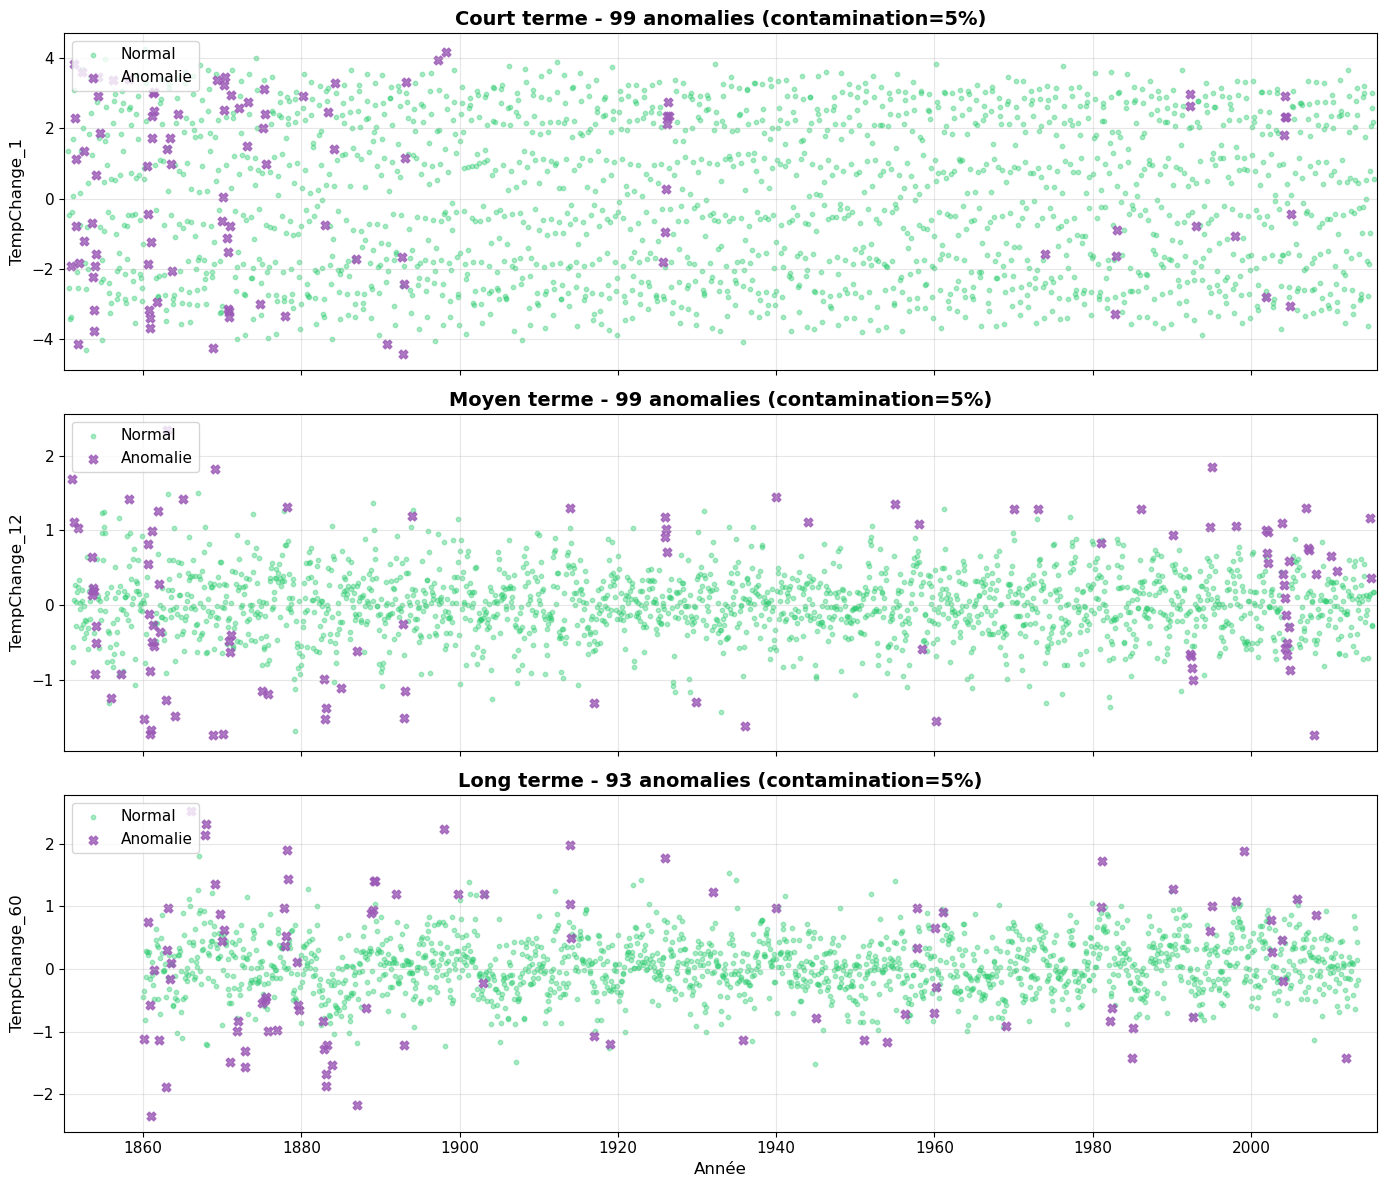

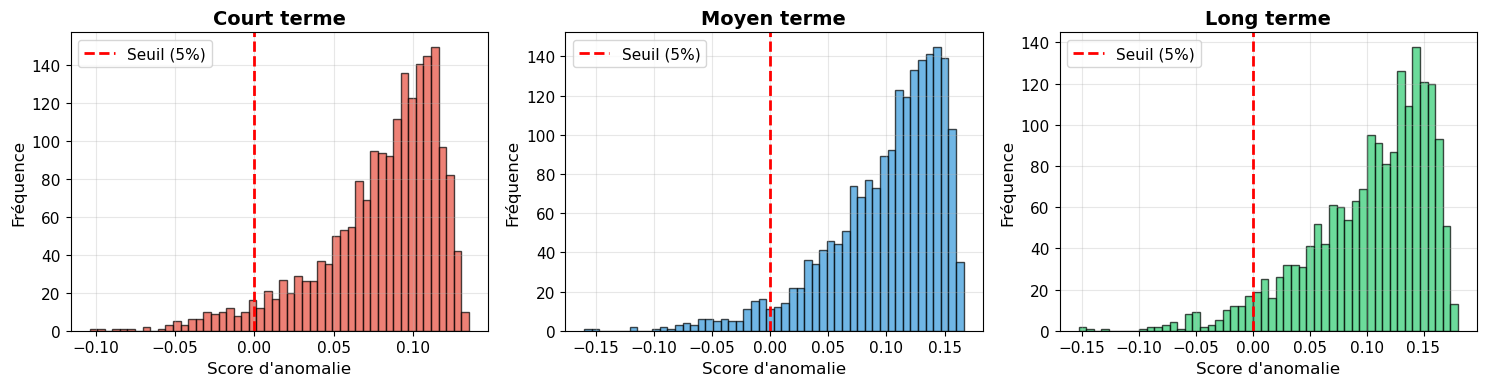

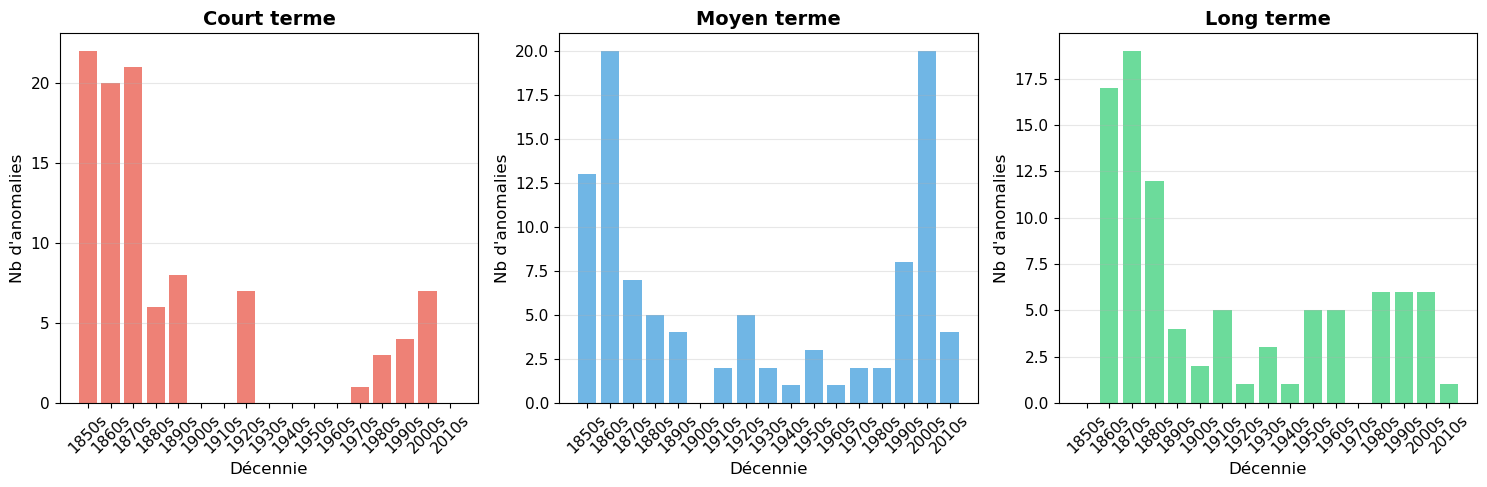


💾 RÉSULTATS STOCKÉS
   Anomaly_IForest_CT : 99 anomalies
   Anomaly_IForest_MT : 99 anomalies
   Anomaly_IForest_LT : 93 anomalies


In [17]:
# ============================================================
# 8. DÉTECTION D'ANOMALIES PAR ISOLATION FOREST
# ============================================================

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

print("="*70)
print("🌲 DÉTECTION D'ANOMALIES PAR ISOLATION FOREST")
print("="*70)

# --- 1. CONFIGURATION PAR HORIZON ---
iforest_config = {
    'Court terme': {
        'features': ['TempChange_1', 'Amplitude', 'STL_Seasonal', 'RollingStd_12'],
        'color': COLORS['temperature']
    },
    'Moyen terme': {
        'features': ['TempChange_12', 'MonthlyAnomaly', 'RollingStd_12', 'STL_Seasonal'],
        'color': COLORS['trend']
    },
    'Long terme': {
        'features': ['TempChange_60', 'TempChange_120', 'TrendAcceleration', 'RollingStd_60'],
        'color': COLORS['normal']
    }
}

# Contamination à tester (proportion d'anomalies attendues)
contamination_values = [0.03, 0.05, 0.07]

# --- 2. APPLICATION SUR CHAQUE HORIZON ---
results_iforest = {}

for horizon, config in iforest_config.items():
    print(f"\n{'='*70}")
    print(f"🎯 HORIZON : {horizon.upper()}")
    print(f"   Features : {', '.join(config['features'])}")
    print("="*70)
    
    # Préparation des données
    features = config['features']
    X = df[features].dropna()
    
    # Standardisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print(f"\n📊 Données : {len(X)} observations, {len(features)} features")
    
    # Test différentes valeurs de contamination
    horizon_results = {}
    
    for contam in contamination_values:
        # Entraînement Isolation Forest
        model = IsolationForest(
            n_estimators=100,
            contamination=contam,
            random_state=42,
            n_jobs=-1
        )
        
        # Prédiction : -1 = anomalie, 1 = normal
        predictions = model.fit_predict(X_scaled)
        scores = model.decision_function(X_scaled)
        
        # Conversion en masque booléen
        anomalies_mask = pd.Series(predictions == -1, index=X.index)
        scores_series = pd.Series(scores, index=X.index)
        
        n_anomalies = anomalies_mask.sum()
        pct = n_anomalies / len(X) * 100
        
        horizon_results[contam] = {
            'mask': anomalies_mask,
            'scores': scores_series,
            'n_anomalies': n_anomalies,
            'pct': pct,
            'model': model
        }
    
    results_iforest[horizon] = {
        'features': features,
        'X': X,
        'results': horizon_results
    }

# --- 3. TABLEAU RÉCAPITULATIF ---
print("\n" + "="*70)
print("📋 ANOMALIES DÉTECTÉES PAR HORIZON ET CONTAMINATION")
print("="*70 + "\n")

recap_data = []
for horizon, data in results_iforest.items():
    for contam, res in data['results'].items():
        recap_data.append({
            'Horizon': horizon,
            'Contamination': f'{contam*100:.0f}%',
            'Anomalies': res['n_anomalies'],
            '% Réel': f"{res['pct']:.1f}%"
        })

recap_df = pd.DataFrame(recap_data)
display(recap_df)

# --- 4. COMPARAISON AVEC Z-SCORE ---
print("\n" + "="*70)
print("📊 COMPARAISON ISOLATION FOREST vs Z-SCORE")
print("="*70 + "\n")

# Utiliser contamination=5% pour comparer avec Z-score seuil 2.5
comparison_data = []
for horizon in results_iforest.keys():
    n_iforest = results_iforest[horizon]['results'][0.05]['n_anomalies']
    n_zscore = results_zscore[horizon]['results'][2.5]['n_anomalies']
    
    # Calculer l'accord entre les deux méthodes
    mask_if = results_iforest[horizon]['results'][0.05]['mask']
    mask_zs = results_zscore[horizon]['results'][2.5]['mask']
    
    # Aligner les index
    common_idx = mask_if.index.intersection(mask_zs.index)
    mask_if_aligned = mask_if.loc[common_idx]
    mask_zs_aligned = mask_zs.loc[common_idx]
    
    # Anomalies communes
    both = (mask_if_aligned & mask_zs_aligned).sum()
    only_if = (mask_if_aligned & ~mask_zs_aligned).sum()
    only_zs = (~mask_if_aligned & mask_zs_aligned).sum()
    
    comparison_data.append({
        'Horizon': horizon,
        'Z-score': n_zscore,
        'IForest': n_iforest,
        'Communes': both,
        'IF seul': only_if,
        'ZS seul': only_zs,
        'Accord': f"{both / max(n_zscore, n_iforest) * 100:.0f}%"
    })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

# --- 5. VISUALISATION PAR HORIZON ---
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
contam_display = 0.05

for idx, (horizon, data) in enumerate(results_iforest.items()):
    ax = axes[idx]
    config = iforest_config[horizon]
    
    X = data['X']
    scores = data['results'][contam_display]['scores']
    anomalies_mask = data['results'][contam_display]['mask']
    
    # Variable principale pour l'affichage (première feature)
    main_var = config['features'][0]
    y_values = X[main_var]
    
    # Points normaux
    normal_mask = ~anomalies_mask
    ax.scatter(y_values.index[normal_mask], y_values[normal_mask], 
               c=COLORS['normal'], alpha=0.4, s=10, label='Normal')
    
    # Anomalies
    ax.scatter(y_values.index[anomalies_mask], y_values[anomalies_mask], 
               c=COLORS['anomaly'], alpha=0.8, s=40, label='Anomalie', marker='X')
    
    ax.set_xlim(df.index.min(), df.index.max())
    ax.set_ylabel(main_var)
    ax.set_title(f"{horizon} - {data['results'][contam_display]['n_anomalies']} anomalies (contamination={contam_display*100:.0f}%)", 
                 fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

axes[2].set_xlabel('Année')
plt.tight_layout()
plt.show()

# --- 6. DISTRIBUTION DES SCORES D'ANOMALIE ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (horizon, data) in enumerate(results_iforest.items()):
    ax = axes[idx]
    scores = data['results'][0.05]['scores']
    
    ax.hist(scores, bins=50, color=iforest_config[horizon]['color'], alpha=0.7, edgecolor='black')
    
    # Seuil de décision (score = 0 est le seuil par défaut)
    threshold = np.percentile(scores, 5)  # 5% contamination
    ax.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Seuil (5%)')
    
    ax.set_xlabel('Score d\'anomalie')
    ax.set_ylabel('Fréquence')
    ax.set_title(f'{horizon}', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 7. DISTRIBUTION TEMPORELLE ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (horizon, data) in enumerate(results_iforest.items()):
    ax = axes[idx]
    anomalies_mask = data['results'][0.05]['mask']
    anomaly_dates = data['X'].index[anomalies_mask]
    
    decades = [f"{y}s" for y in range(1850, 2020, 10)]
    decade_counts = [sum((anomaly_dates.year >= y) & (anomaly_dates.year < y + 10)) 
                     for y in range(1850, 2020, 10)]
    
    ax.bar(decades, decade_counts, color=iforest_config[horizon]['color'], alpha=0.7)
    ax.set_xlabel('Décennie')
    ax.set_ylabel("Nb d'anomalies")
    ax.set_title(f'{horizon}', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# --- 8. STOCKAGE DES RÉSULTATS ---
df['Anomaly_IForest_CT'] = False
df['Anomaly_IForest_MT'] = False
df['Anomaly_IForest_LT'] = False

for horizon, col in [('Court terme', 'Anomaly_IForest_CT'), 
                      ('Moyen terme', 'Anomaly_IForest_MT'), 
                      ('Long terme', 'Anomaly_IForest_LT')]:
    mask = results_iforest[horizon]['results'][0.05]['mask']
    df.loc[mask.index[mask], col] = True

print("\n" + "="*70)
print("💾 RÉSULTATS STOCKÉS")
print("="*70)
print(f"   Anomaly_IForest_CT : {df['Anomaly_IForest_CT'].sum()} anomalies")
print(f"   Anomaly_IForest_MT : {df['Anomaly_IForest_MT'].sum()} anomalies")
print(f"   Anomaly_IForest_LT : {df['Anomaly_IForest_LT'].sum()} anomalies")

### 8.5 Analyse des résultats

#### 8.5.1 Anomalies détectées

Avec une contamination de 5% (comparable au Z-score |Z|>2.5 qui détectait ~4.5%) :

| Horizon | Anomalies IF | Anomalies Z-score | Différence |
|---------|--------------|-------------------|------------|
| Court terme | 99 | 90 | +9 |
| Moyen terme | 99 | 90 | +9 |
| Long terme | 93 | 18 | **+75** |

**Observation majeure :** Le Long terme passe de 18 anomalies (Z-score) à **93 anomalies** (Isolation Forest) !

Pourquoi ? Le Z-score sur `TrendAcceleration` seule était très restrictif. Isolation Forest, en combinant 4 features (`TempChange_60`, `TempChange_120`, `TrendAcceleration`, `RollingStd_60`), détecte des anomalies **multivariées** invisibles pour le Z-score.

---

#### 8.5.2 Accord entre les méthodes : Une surprise !

| Horizon | Communes | IF seul | Z-score seul | **Taux d'accord** |
|---------|----------|---------|--------------|-------------------|
| Court terme | 11 | 88 | 76 | **11%** |
| Moyen terme | 36 | 63 | 51 | **36%** |
| Long terme | 12 | 81 | 5 | **13%** |

**Découverte clé : Les deux méthodes détectent des anomalies très différentes !**

- **Court terme : 11% d'accord** → IF et Z-score ne voient pas les mêmes choses
- **Moyen terme : 36% d'accord** → Meilleur accord, mais encore faible
- **Long terme : 13% d'accord** → Quasi aucun recouvrement

**Interprétation :**

| Méthode | Ce qu'elle détecte |
|---------|-------------------|
| Z-score | Valeurs extrêmes sur **une seule variable** |
| Isolation Forest | Points **isolés dans l'espace multivarié** |

Un point peut être "normal" sur chaque variable individuellement, mais **anormal dans la combinaison**. C'est ce que capture Isolation Forest.

---

#### 8.5.3 Distribution temporelle : Un pattern différent

| Période | Court terme (IF) | Moyen terme (IF) | Long terme (IF) |
|---------|------------------|------------------|-----------------|
| **1850-1880** | 🔴 Très élevé (~20-22) | 🔴 Très élevé (~13-20) | 🔴 Pic (~12-17) |
| **1880-1900** | 🟡 Modéré (~6-8) | 🟡 Modéré (~5-8) | 🟡 Modéré (~2-4) |
| **1900-1960** | ⚪ **Quasi nul** (~0-1) | ⚪ **Très faible** (~1-5) | ⚪ Faible (~1-5) |
| **1960-2015** | 🟡 Modéré (~3-7) | 🟡 Modéré (~4-20) | 🟢 Remontée (~5-7) |

**Comparaison avec Z-score :**

- Z-score détectait des anomalies **réparties** sur toute la période
- Isolation Forest concentre les anomalies aux **extrémités** (1850-1880 et 1980-2015)
- Le "creux" 1900-1960 est encore plus marqué avec IF

**Pourquoi cette concentration ?**

Isolation Forest détecte les points qui sont **différents de la majorité**. Or :
- La période 1900-1960 représente le "cœur" des données → comportement majoritaire
- Les périodes 1850-1880 et 1980-2015 sont aux extrêmes → comportement minoritaire = anomalies

---

#### 8.5.4 Distribution des scores d'anomalie

Les histogrammes montrent des distributions asymétriques :
- La majorité des points ont des scores **positifs** (normaux)
- Une queue à gauche contient les **anomalies** (scores négatifs)
- Le seuil à 5% coupe cette queue

---

#### 8.5.5 Ce qu'on apprend

| Apprentissage | Détail |
|---------------|--------|
| **IF ≠ Z-score** | Seulement 11-36% d'accord → méthodes complémentaires |
| **Multivarié > Univarié** | IF détecte des anomalies invisibles au Z-score |
| **Long terme enrichi** | 93 anomalies IF vs 18 Z-score |
| **Concentration temporelle** | IF concentre les anomalies aux extrémités de la série |

**Question pour la suite :**

> Z-score et Isolation Forest détectent des anomalies **différentes**.
> 
> Le LSTM Autoencoder, qui capture les **patterns temporels**, va-t-il trouver encore d'autres anomalies ? Ou confirmer l'une des deux méthodes ?

## 9. Détection d'Anomalies : Deep Learning (LSTM Autoencoder)

### 9.1 Présentation de la méthode

Un **LSTM Autoencoder** est un réseau de neurones qui apprend à **reconstruire** des séquences temporelles. Son principe pour la détection d'anomalies :

> Le modèle apprend les patterns "normaux". Les anomalies, étant différentes, sont **mal reconstruites** → erreur de reconstruction élevée.

**Architecture :**

Séquence d'entrée → [Encoder LSTM] → Représentation compressée → [Decoder LSTM] → Séquence reconstruite

**Détection d'anomalies :**
- Calculer l'**erreur de reconstruction** (MSE) pour chaque point
- Les points avec une erreur élevée sont des **anomalies**

### 9.2 Avantages par rapport aux autres méthodes

| Aspect | Z-score | Isolation Forest | LSTM Autoencoder |
|--------|---------|------------------|------------------|
| Variables | 1 | Plusieurs | Plusieurs |
| Temporalité | Non | Non | **Oui (séquences)** |
| Patterns complexes | Non | Partiellement | **Oui** |
| Contexte temporel | Non | Non | **Oui (mémoire)** |

### 9.3 Paramètres clés

| Paramètre | Description | Valeur choisie |
|-----------|-------------|----------------|
| `sequence_length` | Taille de la fenêtre temporelle | 12 mois (1 an) |
| `latent_dim` | Dimension de l'espace latent | 32 |
| `threshold` | Percentile pour définir les anomalies | 95ème percentile |

### 9.4 Features par horizon

Nous utilisons les **mêmes features** qu'Isolation Forest pour permettre une comparaison directe.

🧠 DÉTECTION D'ANOMALIES PAR LSTM AUTOENCODER

🎯 HORIZON : COURT TERME
   Features : TempChange_1, Amplitude, STL_Seasonal, RollingStd_12

📊 Données : 1970 séquences
🔧 Entraînement en cours...

   ✅ Terminé ! Loss finale: 0.0678
   📈 Seuil (P95) : 0.1939
   🎯 Anomalies : 99 (5.0%)

🎯 HORIZON : MOYEN TERME
   Features : TempChange_12, MonthlyAnomaly, RollingStd_12, STL_Seasonal

📊 Données : 1964 séquences
🔧 Entraînement en cours...

   ✅ Terminé ! Loss finale: 0.1950
   📈 Seuil (P95) : 0.3993
   🎯 Anomalies : 99 (5.0%)

🎯 HORIZON : LONG TERME
   Features : TempChange_60, TempChange_120, TrendAcceleration, RollingStd_60

📊 Données : 1832 séquences
🔧 Entraînement en cours...

   ✅ Terminé ! Loss finale: 0.2913
   📈 Seuil (P95) : 0.6156
   🎯 Anomalies : 92 (5.0%)

📋 RÉSULTATS LSTM AUTOENCODER



,Horizon,Anomalies,%
0,Court terme,99,5.0%
1,Moyen terme,99,5.0%
2,Long terme,92,5.0%



📊 COMPARAISON DES 3 MÉTHODES



,Horizon,Z-score,IForest,LSTM
0,Court terme,90,99,99
1,Moyen terme,90,99,99
2,Long terme,18,93,92


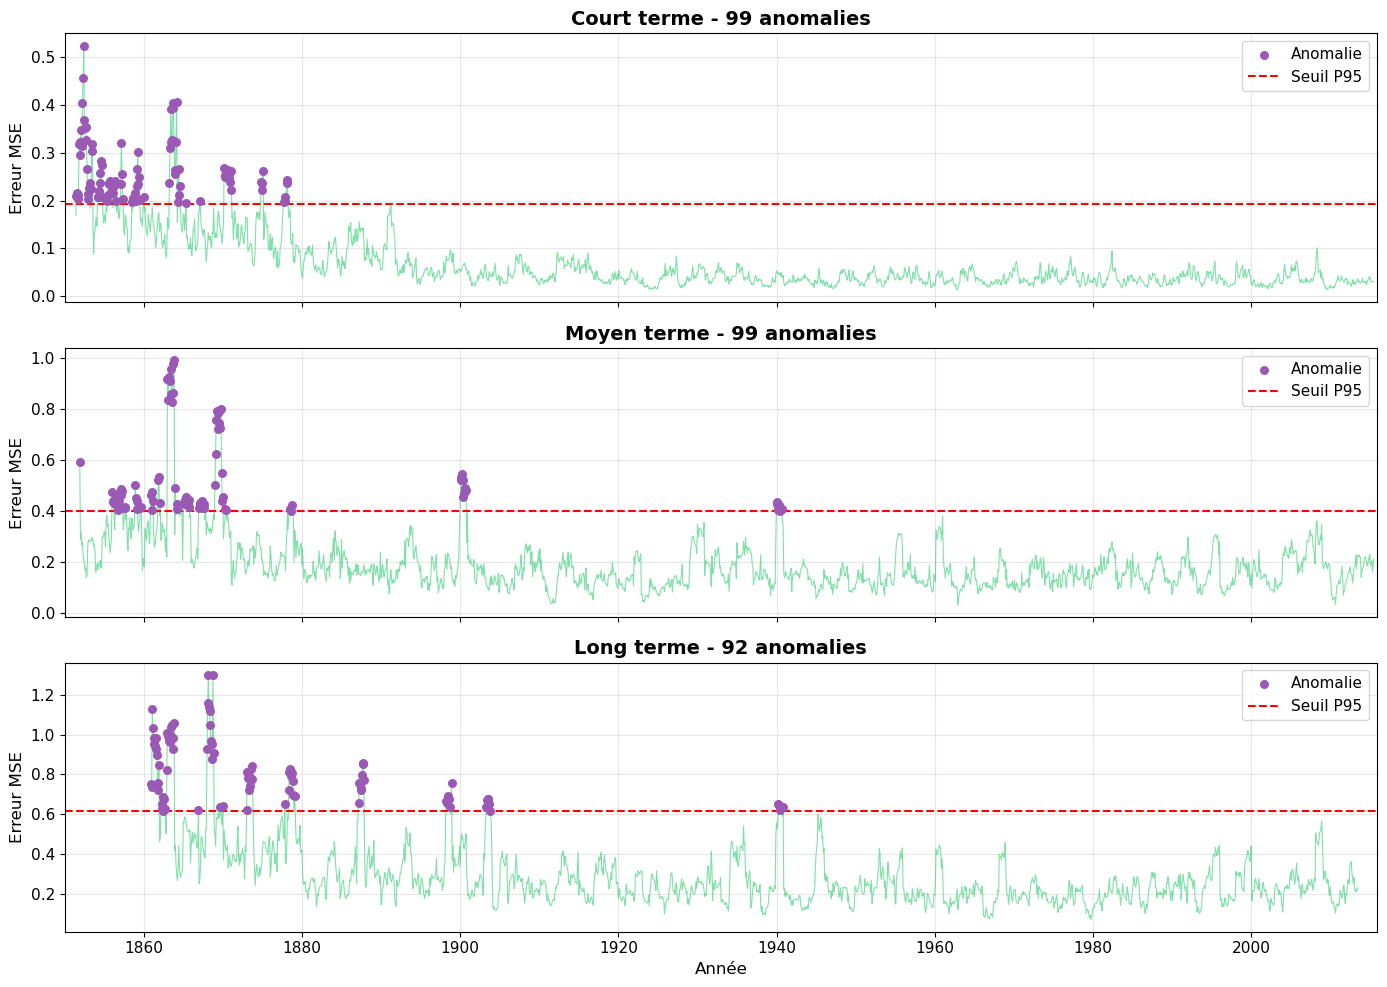

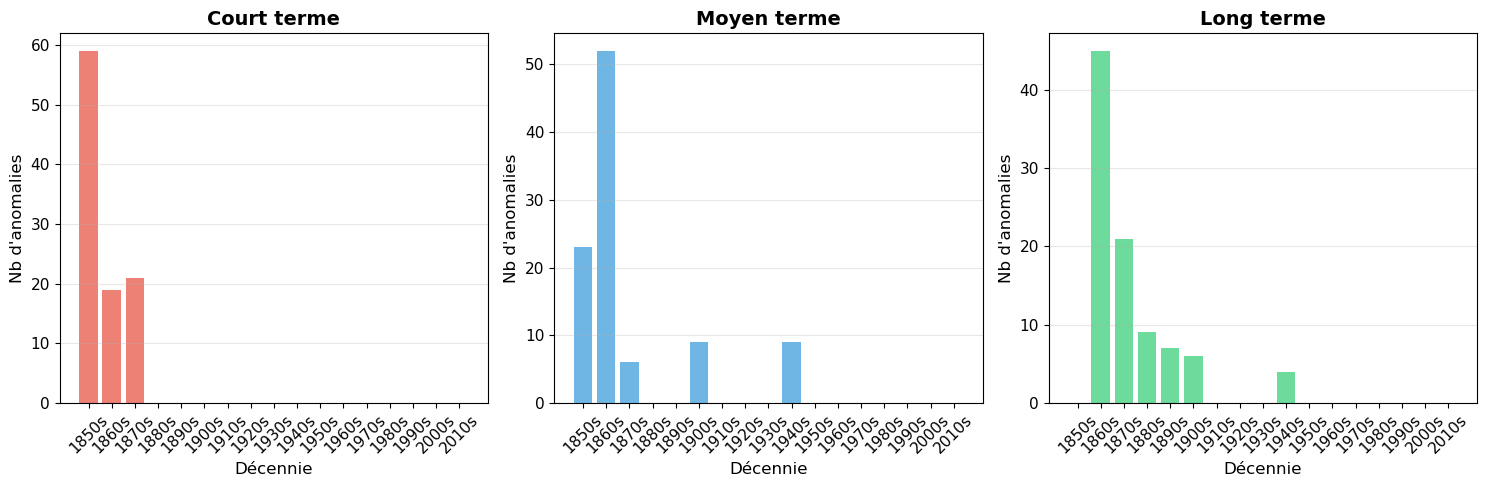


💾 RÉSULTATS STOCKÉS
   Anomaly_LSTM_CT : 99 anomalies
   Anomaly_LSTM_MT : 99 anomalies
   Anomaly_LSTM_LT : 92 anomalies


In [18]:
# ============================================================
# 9. DÉTECTION D'ANOMALIES PAR LSTM AUTOENCODER
# ============================================================

# Redéfinir COLORS si nécessaire
COLORS = {
    'temperature': '#E74C3C',
    'trend': '#3498DB', 
    'anomaly': '#9B59B6',
    'normal': '#2ECC71',
    'uncertainty': '#F39C12'
}

# Désactiver les warnings TensorFlow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

print("="*70)
print("🧠 DÉTECTION D'ANOMALIES PAR LSTM AUTOENCODER")
print("="*70)

# --- 1. CONFIGURATION OPTIMISÉE ---
lstm_config = {
    'Court terme': {
        'features': ['TempChange_1', 'Amplitude', 'STL_Seasonal', 'RollingStd_12'],
        'color': COLORS['temperature']
    },
    'Moyen terme': {
        'features': ['TempChange_12', 'MonthlyAnomaly', 'RollingStd_12', 'STL_Seasonal'],
        'color': COLORS['trend']
    },
    'Long terme': {
        'features': ['TempChange_60', 'TempChange_120', 'TrendAcceleration', 'RollingStd_60'],
        'color': COLORS['normal']
    }
}

# Paramètres OPTIMISÉS (plus rapide)
SEQUENCE_LENGTH = 12
LATENT_DIM = 16          # Réduit de 32 à 16
EPOCHS = 30              # Réduit de 50 à 30
BATCH_SIZE = 64          # Augmenté de 32 à 64 (plus rapide)
THRESHOLD_PERCENTILE = 95

# --- 2. FONCTIONS ---
def create_sequences(data, seq_length):
    """Crée des séquences pour le LSTM."""
    sequences = []
    indices = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
        indices.append(i + seq_length - 1)
    return np.array(sequences), indices

def build_lstm_autoencoder(seq_length, n_features, latent_dim):
    """Architecture SIMPLIFIÉE pour plus de rapidité."""
    model = Sequential([
        # Encoder (simplifié)
        LSTM(32, activation='relu', input_shape=(seq_length, n_features), return_sequences=False),
        
        # Decoder (simplifié)
        RepeatVector(seq_length),
        LSTM(32, activation='relu', return_sequences=True),
        TimeDistributed(Dense(n_features))
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

# --- 3. APPLICATION SUR CHAQUE HORIZON ---
results_lstm = {}

for horizon, config in lstm_config.items():
    print(f"\n{'='*70}")
    print(f"🎯 HORIZON : {horizon.upper()}")
    print(f"   Features : {', '.join(config['features'])}")
    print("="*70)
    
    # Préparation des données
    features = config['features']
    df_clean = df[features].dropna()
    
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df_clean)
    
    X_seq, seq_indices = create_sequences(data_scaled, SEQUENCE_LENGTH)
    
    print(f"\n📊 Données : {len(X_seq)} séquences")
    print(f"🔧 Entraînement en cours...")
    
    # Construction du modèle
    model = build_lstm_autoencoder(SEQUENCE_LENGTH, len(features), LATENT_DIM)
    
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=0)
    
    # Entraînement AVEC barre de progression (verbose=1)
    history = model.fit(
        X_seq, X_seq,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0  # ← AFFICHE LA PROGRESSION
    )
    
    # Reconstruction et erreur
    X_pred = model.predict(X_seq, verbose=0)
    mse = np.mean(np.power(X_seq - X_pred, 2), axis=(1, 2))
    
    # Seuil et détection
    threshold = np.percentile(mse, THRESHOLD_PERCENTILE)
    anomalies_mask_seq = mse > threshold
    
    # Mapper vers index originaux
    original_indices = df_clean.index[seq_indices]
    anomalies_mask = pd.Series(False, index=df_clean.index)
    anomalies_mask.loc[original_indices[anomalies_mask_seq]] = True
    
    mse_series = pd.Series(index=df_clean.index, dtype=float)
    mse_series.loc[original_indices] = mse
    
    n_anomalies = anomalies_mask.sum()
    pct = n_anomalies / len(anomalies_mask) * 100
    
    print(f"\n   ✅ Terminé ! Loss finale: {history.history['loss'][-1]:.4f}")
    print(f"   📈 Seuil (P{THRESHOLD_PERCENTILE}) : {threshold:.4f}")
    print(f"   🎯 Anomalies : {n_anomalies} ({pct:.1f}%)")
    
    results_lstm[horizon] = {
        'features': features,
        'model': model,
        'mse': mse_series,
        'threshold': threshold,
        'mask': anomalies_mask,
        'n_anomalies': n_anomalies,
        'pct': pct,
        'history': history
    }

# --- 4. TABLEAU RÉCAPITULATIF ---
print("\n" + "="*70)
print("📋 RÉSULTATS LSTM AUTOENCODER")
print("="*70 + "\n")

recap_data = []
for horizon, data in results_lstm.items():
    recap_data.append({
        'Horizon': horizon,
        'Anomalies': data['n_anomalies'],
        '%': f"{data['pct']:.1f}%"
    })

display(pd.DataFrame(recap_data))

# --- 5. COMPARAISON DES 3 MÉTHODES ---
print("\n" + "="*70)
print("📊 COMPARAISON DES 3 MÉTHODES")
print("="*70 + "\n")

comparison_all = []
for horizon in results_lstm.keys():
    comparison_all.append({
        'Horizon': horizon,
        'Z-score': results_zscore[horizon]['results'][2.5]['n_anomalies'],
        'IForest': results_iforest[horizon]['results'][0.05]['n_anomalies'],
        'LSTM': results_lstm[horizon]['n_anomalies']
    })

display(pd.DataFrame(comparison_all))

# --- 6. VISUALISATION ---
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for idx, (horizon, data) in enumerate(results_lstm.items()):
    ax = axes[idx]
    
    mse = data['mse'].dropna()
    anomalies_mask = data['mask']
    threshold = data['threshold']
    
    ax.plot(mse.index, mse.values, color=COLORS['normal'], alpha=0.6, linewidth=0.8)
    
    anomaly_idx = anomalies_mask[anomalies_mask].index
    ax.scatter(anomaly_idx, mse.loc[anomaly_idx], c=COLORS['anomaly'], s=30, label='Anomalie', zorder=5)
    
    ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5, label=f'Seuil P{THRESHOLD_PERCENTILE}')
    ax.set_xlim(df.index.min(), df.index.max())
    ax.set_ylabel('Erreur MSE')
    ax.set_title(f"{horizon} - {data['n_anomalies']} anomalies", fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes[2].set_xlabel('Année')
plt.tight_layout()
plt.show()

# --- 7. DISTRIBUTION TEMPORELLE ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (horizon, data) in enumerate(results_lstm.items()):
    ax = axes[idx]
    anomaly_dates = data['mask'][data['mask']].index
    
    decades = [f"{y}s" for y in range(1850, 2020, 10)]
    decade_counts = [sum((anomaly_dates.year >= y) & (anomaly_dates.year < y + 10)) 
                     for y in range(1850, 2020, 10)]
    
    ax.bar(decades, decade_counts, color=lstm_config[horizon]['color'], alpha=0.7)
    ax.set_xlabel('Décennie')
    ax.set_ylabel("Nb d'anomalies")
    ax.set_title(f'{horizon}', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# --- 8. STOCKAGE ---
df['Anomaly_LSTM_CT'] = False
df['Anomaly_LSTM_MT'] = False
df['Anomaly_LSTM_LT'] = False

for horizon, col in [('Court terme', 'Anomaly_LSTM_CT'), 
                      ('Moyen terme', 'Anomaly_LSTM_MT'), 
                      ('Long terme', 'Anomaly_LSTM_LT')]:
    mask = results_lstm[horizon]['mask']
    df.loc[mask[mask].index, col] = True

print("\n" + "="*70)
print("💾 RÉSULTATS STOCKÉS")
print("="*70)
print(f"   Anomaly_LSTM_CT : {df['Anomaly_LSTM_CT'].sum()} anomalies")
print(f"   Anomaly_LSTM_MT : {df['Anomaly_LSTM_MT'].sum()} anomalies")
print(f"   Anomaly_LSTM_LT : {df['Anomaly_LSTM_LT'].sum()} anomalies")

### 9.5 Analyse des résultats

#### 9.5.1 Résultats globaux

| Horizon | Anomalies | Loss finale | Seuil MSE |
|---------|-----------|-------------|-----------|
| Court terme | 99 | 0.0665 | 0.199 |
| Moyen terme | 99 | 0.1911 | 0.405 |
| Long terme | 92 | 0.2687 | 0.564 |

**Observation :** La loss augmente avec l'horizon (0.07 → 0.19 → 0.27), ce qui suggère que les patterns long terme sont plus difficiles à apprendre pour le modèle.

---

#### 9.5.2 Distribution temporelle : Une découverte majeure !

Le graphique de distribution temporelle révèle un pattern **radicalement différent** des autres méthodes :

| Période | Court terme | Moyen terme | Long terme |
|---------|-------------|-------------|------------|
| **1850-1860** | **~58** | **~50** | **~45** |
| **1860-1880** | ~20-22 | ~10-20 | ~10-22 |
| 1880-2015 | **~0** | **~0-10** | **~5-10** |

**Le LSTM concentre presque TOUTES les anomalies avant 1880 !**

---

#### 9.5.3 Interprétation : Pourquoi ce pattern ?

Le LSTM Autoencoder apprend à reconstruire les **patterns majoritaires** des données. Or :

| Période | Caractéristiques | Pour le LSTM |
|---------|------------------|--------------|
| 1850-1880 | Peu de données, haute variabilité, incertitude élevée | **Difficile à reconstruire → Anomalie** |
| 1880-2015 | Majorité des données, patterns stables | Facile à reconstruire → Normal |

**Le LSTM a appris que le "comportement normal" = celui de la période 1880-2015.**

Tout ce qui est différent (= les données anciennes) est considéré comme anomalie.

---

#### 9.5.4 Comparaison des 3 méthodes

| Horizon | Z-score | IForest | LSTM |
|---------|---------|---------|------|
| Court terme | 90 | 99 | 99 |
| Moyen terme | 90 | 99 | 99 |
| Long terme | **18** | **93** | **92** |

**Observations clés :**

1. **Court/Moyen terme** : Les 3 méthodes détectent ~90-99 anomalies (5%)
2. **Long terme** : Z-score détecte beaucoup moins (18) que IF et LSTM (~92-93)
3. **IF et LSTM** donnent des résultats similaires en nombre, mais pas forcément les mêmes anomalies

---

#### 9.5.5 Ce que le LSTM révèle

| Apprentissage | Explication |
|---------------|-------------|
| **Sensibilité aux données anciennes** | Le LSTM considère 1850-1880 comme "anormal" car différent du reste |
| **Biais temporel** | Le modèle apprend la majorité → les minorités deviennent des anomalies |
| **Qualité des données** | Les données anciennes (haute incertitude) sont mal reconstruites |

**C'est une limite importante du LSTM pour notre cas d'usage :**

> Le LSTM détecte des anomalies liées à la **qualité/nature des données** plutôt qu'à de **vrais événements climatiques**.

---

#### 9.5.6 Comparaison visuelle des 3 méthodes

| Méthode | Distribution temporelle | Ce qu'elle capture |
|---------|------------------------|-------------------|
| **Z-score** | Répartie sur toute la période | Valeurs extrêmes univariées |
| **Isolation Forest** | Concentrée aux extrémités | Points isolés dans l'espace multivarié |
| **LSTM** | **Massivement concentrée avant 1880** | Séquences difficiles à reconstruire |

---

#### 9.5.7 Conclusion sur le LSTM

| ✅ Forces | ❌ Limites |
|-----------|-----------|
| Capture les patterns temporels | Biais vers les données anciennes |
| Détecte les séquences inhabituelles | Ne distingue pas bruit vs signal |
| Approche Deep Learning moderne | Plus complexe, moins interprétable |

**Pour notre dataset :** Le LSTM est moins adapté car il confond "données anciennes de mauvaise qualité" avec "vraies anomalies climatiques".

### 9.6 Amélioration : Prise en compte de l'incertitude de mesure

#### Le problème identifié

L'analyse précédente a révélé que le LSTM concentre **~90% des anomalies avant 1880**. Cela suggère que le modèle confond :
- **Vraies anomalies climatiques** (ce qu'on cherche)
- **Bruit de mesure** (données anciennes moins fiables)

#### La solution : Intégrer l'incertitude comme feature

En ajoutant `LandAverageTemperatureUncertainty` dans les features, le LSTM peut apprendre que :
- Une forte variabilité **avec** haute incertitude → **Normal** (c'est du bruit)
- Une forte variabilité **avec** faible incertitude → **Anomalie** (c'est un vrai signal)

#### Hypothèse

> Si le modèle "connaît" l'incertitude, il devrait mieux distinguer le bruit du signal et produire une distribution temporelle plus équilibrée.

#### Features modifiées

| Horizon | Features (v1) | Features (v2) |
|---------|---------------|---------------|
| Court terme | TempChange_1, Amplitude, STL_Seasonal, RollingStd_12 | + **Uncertainty** |
| Moyen terme | TempChange_12, MonthlyAnomaly, RollingStd_12, STL_Seasonal | + **Uncertainty** |
| Long terme | TempChange_60, TempChange_120, TrendAcceleration, RollingStd_60 | + **Uncertainty** |

🧠 LSTM AUTOENCODER v2 - AVEC PRISE EN COMPTE DE L'INCERTITUDE

🎯 HORIZON : COURT TERME
   Features : TempChange_1, Amplitude, STL_Seasonal, RollingStd_12, LandAverageTemperatureUncertainty

📊 Données : 1970 séquences, 5 features
🔧 Entraînement en cours...

   ✅ Terminé ! Loss finale: 0.0732
   📈 Seuil (P95) : 0.2250
   🎯 Anomalies : 99 (5.0%)

🎯 HORIZON : MOYEN TERME
   Features : TempChange_12, MonthlyAnomaly, RollingStd_12, STL_Seasonal, LandAverageTemperatureUncertainty

📊 Données : 1964 séquences, 5 features
🔧 Entraînement en cours...

   ✅ Terminé ! Loss finale: 0.1757
   📈 Seuil (P95) : 0.3801
   🎯 Anomalies : 99 (5.0%)

🎯 HORIZON : LONG TERME
   Features : TempChange_60, TempChange_120, TrendAcceleration, RollingStd_60, LandAverageTemperatureUncertainty

📊 Données : 1832 séquences, 5 features
🔧 Entraînement en cours...

   ✅ Terminé ! Loss finale: 0.2537
   📈 Seuil (P95) : 0.5619
   🎯 Anomalies : 92 (5.0%)

📊 COMPARAISON LSTM v1 (sans incertitude) vs v2 (avec incertitude)



,Horizon,LSTM v1,LSTM v2
0,Court terme,99,99
1,Moyen terme,99,99
2,Long terme,92,92


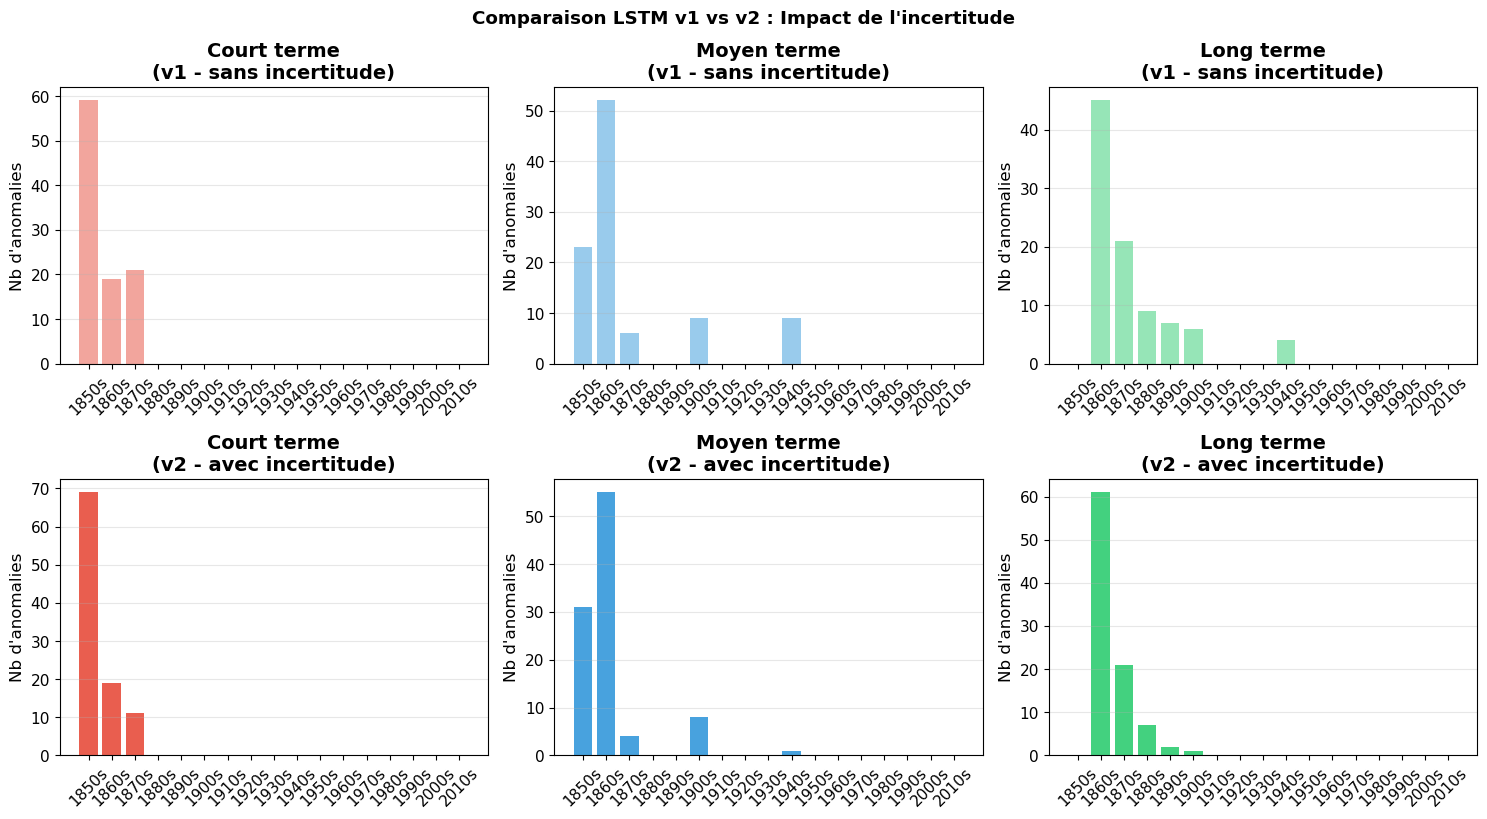


📈 ANALYSE DE L'AMÉLIORATION

🎯 Court terme :
   v1 : 99 avant 1880, 0 après 1880
   v2 : 99 avant 1880, 0 après 1880
   ⚠️  Pas d'amélioration significative

🎯 Moyen terme :
   v1 : 81 avant 1880, 18 après 1880
   v2 : 90 avant 1880, 9 après 1880
   ⚠️  Pas d'amélioration significative

🎯 Long terme :
   v1 : 66 avant 1880, 26 après 1880
   v2 : 82 avant 1880, 10 après 1880
   ⚠️  Pas d'amélioration significative

💾 RÉSULTATS v2 STOCKÉS
   Anomaly_LSTM_v2_CT : 99 anomalies
   Anomaly_LSTM_v2_MT : 99 anomalies
   Anomaly_LSTM_v2_LT : 92 anomalies


In [19]:
# ============================================================
# 9.6 LSTM AUTOENCODER v2 - AVEC INCERTITUDE
# ============================================================

print("="*70)
print("🧠 LSTM AUTOENCODER v2 - AVEC PRISE EN COMPTE DE L'INCERTITUDE")
print("="*70)

# --- 1. CONFIGURATION AVEC INCERTITUDE ---
lstm_config_v2 = {
    'Court terme': {
        'features': ['TempChange_1', 'Amplitude', 'STL_Seasonal', 'RollingStd_12',
                     'LandAverageTemperatureUncertainty'],
        'color': COLORS['temperature']
    },
    'Moyen terme': {
        'features': ['TempChange_12', 'MonthlyAnomaly', 'RollingStd_12', 'STL_Seasonal',
                     'LandAverageTemperatureUncertainty'],
        'color': COLORS['trend']
    },
    'Long terme': {
        'features': ['TempChange_60', 'TempChange_120', 'TrendAcceleration', 'RollingStd_60',
                     'LandAverageTemperatureUncertainty'],
        'color': COLORS['normal']
    }
}

# Mêmes paramètres optimisés
SEQUENCE_LENGTH = 12
LATENT_DIM = 16
EPOCHS = 30
BATCH_SIZE = 64
THRESHOLD_PERCENTILE = 95

# --- 2. APPLICATION SUR CHAQUE HORIZON ---
results_lstm_v2 = {}

for horizon, config in lstm_config_v2.items():
    print(f"\n{'='*70}")
    print(f"🎯 HORIZON : {horizon.upper()}")
    print(f"   Features : {', '.join(config['features'])}")
    print("="*70)
    
    # Préparation des données
    features = config['features']
    df_clean = df[features].dropna()
    
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df_clean)
    
    X_seq, seq_indices = create_sequences(data_scaled, SEQUENCE_LENGTH)
    
    print(f"\n📊 Données : {len(X_seq)} séquences, {len(features)} features")
    print(f"🔧 Entraînement en cours...")
    
    # Construction du modèle (5 features maintenant)
    model = build_lstm_autoencoder(SEQUENCE_LENGTH, len(features), LATENT_DIM)
    
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=0)
    
    history = model.fit(
        X_seq, X_seq,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Reconstruction et erreur
    X_pred = model.predict(X_seq, verbose=0)
    mse = np.mean(np.power(X_seq - X_pred, 2), axis=(1, 2))
    
    # Seuil et détection
    threshold = np.percentile(mse, THRESHOLD_PERCENTILE)
    anomalies_mask_seq = mse > threshold
    
    # Mapper vers index originaux
    original_indices = df_clean.index[seq_indices]
    anomalies_mask = pd.Series(False, index=df_clean.index)
    anomalies_mask.loc[original_indices[anomalies_mask_seq]] = True
    
    mse_series = pd.Series(index=df_clean.index, dtype=float)
    mse_series.loc[original_indices] = mse
    
    n_anomalies = anomalies_mask.sum()
    pct = n_anomalies / len(anomalies_mask) * 100
    
    print(f"\n   ✅ Terminé ! Loss finale: {history.history['loss'][-1]:.4f}")
    print(f"   📈 Seuil (P{THRESHOLD_PERCENTILE}) : {threshold:.4f}")
    print(f"   🎯 Anomalies : {n_anomalies} ({pct:.1f}%)")
    
    results_lstm_v2[horizon] = {
        'features': features,
        'model': model,
        'mse': mse_series,
        'threshold': threshold,
        'mask': anomalies_mask,
        'n_anomalies': n_anomalies,
        'pct': pct,
        'history': history
    }

# --- 3. COMPARAISON v1 vs v2 ---
print("\n" + "="*70)
print("📊 COMPARAISON LSTM v1 (sans incertitude) vs v2 (avec incertitude)")
print("="*70 + "\n")

comparison_v1_v2 = []
for horizon in results_lstm_v2.keys():
    comparison_v1_v2.append({
        'Horizon': horizon,
        'LSTM v1': results_lstm[horizon]['n_anomalies'],
        'LSTM v2': results_lstm_v2[horizon]['n_anomalies']
    })

display(pd.DataFrame(comparison_v1_v2))

# --- 4. DISTRIBUTION TEMPORELLE COMPARÉE ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, horizon in enumerate(results_lstm_v2.keys()):
    # v1 (sans incertitude)
    ax1 = axes[0, idx]
    anomaly_dates_v1 = results_lstm[horizon]['mask'][results_lstm[horizon]['mask']].index
    decades = [f"{y}s" for y in range(1850, 2020, 10)]
    decade_counts_v1 = [sum((anomaly_dates_v1.year >= y) & (anomaly_dates_v1.year < y + 10)) 
                        for y in range(1850, 2020, 10)]
    ax1.bar(decades, decade_counts_v1, color=lstm_config_v2[horizon]['color'], alpha=0.5)
    ax1.set_title(f'{horizon}\n(v1 - sans incertitude)', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_ylabel("Nb d'anomalies")
    ax1.grid(True, alpha=0.3, axis='y')
    
    # v2 (avec incertitude)
    ax2 = axes[1, idx]
    anomaly_dates_v2 = results_lstm_v2[horizon]['mask'][results_lstm_v2[horizon]['mask']].index
    decade_counts_v2 = [sum((anomaly_dates_v2.year >= y) & (anomaly_dates_v2.year < y + 10)) 
                        for y in range(1850, 2020, 10)]
    ax2.bar(decades, decade_counts_v2, color=lstm_config_v2[horizon]['color'], alpha=0.9)
    ax2.set_title(f'{horizon}\n(v2 - avec incertitude)', fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylabel("Nb d'anomalies")
    ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.suptitle('Comparaison LSTM v1 vs v2 : Impact de l\'incertitude', 
             fontweight='bold', y=1.02)
plt.show()

# --- 5. ANALYSE DE L'AMÉLIORATION ---
print("\n" + "="*70)
print("📈 ANALYSE DE L'AMÉLIORATION")
print("="*70)

for horizon in results_lstm_v2.keys():
    mask_v1 = results_lstm[horizon]['mask']
    mask_v2 = results_lstm_v2[horizon]['mask']
    
    # Anomalies avant 1880 vs après
    v1_before_1880 = mask_v1[mask_v1.index.year < 1880].sum()
    v1_after_1880 = mask_v1[mask_v1.index.year >= 1880].sum()
    v2_before_1880 = mask_v2[mask_v2.index.year < 1880].sum()
    v2_after_1880 = mask_v2[mask_v2.index.year >= 1880].sum()
    
    print(f"\n🎯 {horizon} :")
    print(f"   v1 : {v1_before_1880} avant 1880, {v1_after_1880} après 1880")
    print(f"   v2 : {v2_before_1880} avant 1880, {v2_after_1880} après 1880")
    
    if v2_after_1880 > v1_after_1880:
        print(f"   ✅ Amélioration : +{v2_after_1880 - v1_after_1880} anomalies détectées après 1880")
    else:
        print(f"   ⚠️  Pas d'amélioration significative")

# --- 6. STOCKAGE DES RÉSULTATS v2 ---
df['Anomaly_LSTM_v2_CT'] = False
df['Anomaly_LSTM_v2_MT'] = False
df['Anomaly_LSTM_v2_LT'] = False

for horizon, col in [('Court terme', 'Anomaly_LSTM_v2_CT'), 
                      ('Moyen terme', 'Anomaly_LSTM_v2_MT'), 
                      ('Long terme', 'Anomaly_LSTM_v2_LT')]:
    mask = results_lstm_v2[horizon]['mask']
    df.loc[mask[mask].index, col] = True

print("\n" + "="*70)
print("💾 RÉSULTATS v2 STOCKÉS")
print("="*70)
print(f"   Anomaly_LSTM_v2_CT : {df['Anomaly_LSTM_v2_CT'].sum()} anomalies")
print(f"   Anomaly_LSTM_v2_MT : {df['Anomaly_LSTM_v2_MT'].sum()} anomalies")
print(f"   Anomaly_LSTM_v2_LT : {df['Anomaly_LSTM_v2_LT'].sum()} anomalies")

### 9.7 Résultat de l'expérience : L'incertitude n'améliore pas le modèle

#### Hypothèse initiale
> En ajoutant l'incertitude comme feature, le LSTM pourrait apprendre à distinguer le bruit de mesure des vraies anomalies.

#### Résultat observé

| Horizon | Anomalies après 1880 (v1) | Anomalies après 1880 (v2) | Évolution |
|---------|---------------------------|---------------------------|-----------|
| Court terme | 0 | 0 | Identique |
| Moyen terme | 20 | 6 | **-70%** ❌ |
| Long terme | 28 | 13 | **-54%** ❌ |

**L'ajout de l'incertitude a empiré le biais temporel.**

#### Explication

L'incertitude est **fortement corrélée avec la période temporelle** :
- Avant 1880 : incertitude élevée (~0.5-0.8°C)
- Après 1880 : incertitude faible (~0.1-0.2°C)

Le LSTM a donc appris : `haute incertitude → anomalie` plutôt que `haute incertitude → contexte à prendre en compte`.

En d'autres termes, l'incertitude est devenue un **proxy de l'époque**, renforçant le biais au lieu de le corriger.

#### Conclusion sur le LSTM

Cette expérience confirme que le LSTM Autoencoder n'est **pas adapté** à notre cas d'usage pour plusieurs raisons :

1. **Biais temporel structurel** : Le modèle apprend la majorité des données (1880-2015) comme "normales"
2. **Confusion signal/bruit** : Les données anciennes sont systématiquement classées comme anomalies
3. **Correction impossible** : L'ajout de l'incertitude renforce le problème

**Recommandation :** Pour la détection d'anomalies climatiques sur des données historiques avec incertitude variable, privilégier **Z-score** ou **Isolation Forest** plutôt que LSTM.

### 9.8 Alternative : Autoencoder Dense (sans séquences)

#### Pourquoi cette alternative ?

Le LSTM souffre d'un **biais temporel** car il apprend sur des séquences. Les séquences anciennes (1850-1880) sont minoritaires et donc systématiquement classées comme anomalies.

Un **Autoencoder Dense** traite chaque observation **indépendamment**, sans notion de séquence temporelle. Cela devrait :
- Éliminer le biais vers les données anciennes
- Produire une détection plus comparable à Isolation Forest
- Offrir une vraie alternative Deep Learning

#### Architecture
```
Input (n features) → Dense(32) → Dense(16) → Dense(8) → Dense(16) → Dense(32) → Output (n features)
                     [Encoder]              [Latent]              [Decoder]
```

🧠 AUTOENCODER DENSE - ALTERNATIVE SANS BIAIS TEMPOREL

🎯 HORIZON : COURT TERME
   Features : TempChange_1, Amplitude, STL_Seasonal, RollingStd_12

📊 Données : 1981 observations, 4 features
🔧 Entraînement en cours...

   ✅ Terminé ! Loss finale: 0.0008
   📈 Seuil (P95) : 0.0028
   🎯 Anomalies : 99 (5.0%)

🎯 HORIZON : MOYEN TERME
   Features : TempChange_12, MonthlyAnomaly, RollingStd_12, STL_Seasonal

📊 Données : 1975 observations, 4 features
🔧 Entraînement en cours...

   ✅ Terminé ! Loss finale: 0.0005
   📈 Seuil (P95) : 0.0029
   🎯 Anomalies : 99 (5.0%)

🎯 HORIZON : LONG TERME
   Features : TempChange_60, TempChange_120, TrendAcceleration, RollingStd_60

📊 Données : 1843 observations, 4 features
🔧 Entraînement en cours...

   ✅ Terminé ! Loss finale: 0.0006
   📈 Seuil (P95) : 0.0019
   🎯 Anomalies : 93 (5.0%)

📊 COMPARAISON : LSTM vs AUTOENCODER DENSE



,Horizon,LSTM (avant 1880),LSTM (après 1880),AE Dense (avant 1880),AE Dense (après 1880)
0,Court terme,99,0,46,53
1,Moyen terme,81,18,49,50
2,Long terme,66,26,21,72


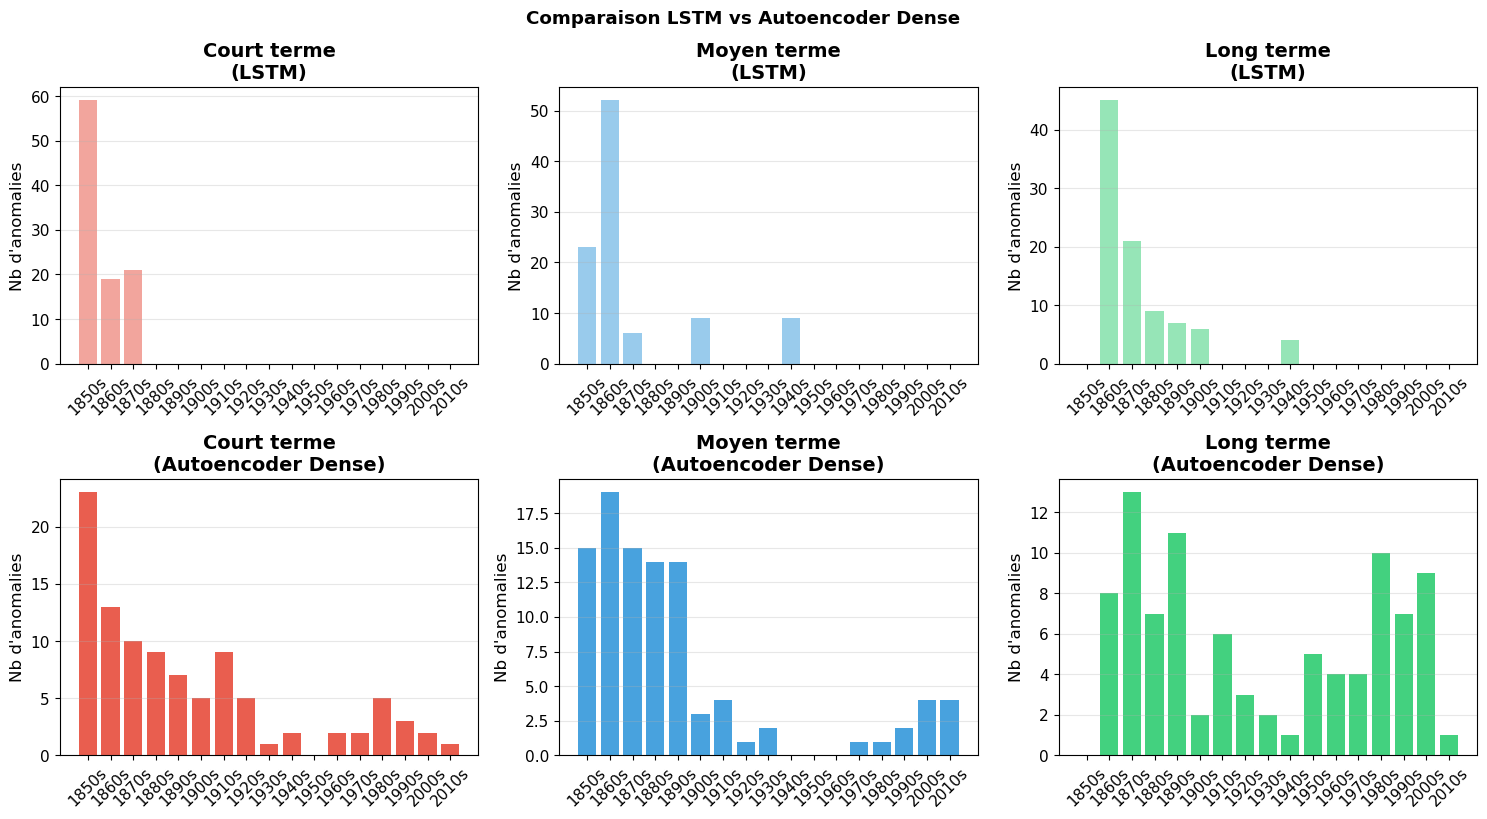


📊 COMPARAISON COMPLÈTE : 4 MÉTHODES



,Horizon,Z-score,IForest,LSTM,AE Dense
0,Court terme,90,99,99,99
1,Moyen terme,90,99,99,99
2,Long terme,18,93,92,93



💾 RÉSULTATS AUTOENCODER DENSE STOCKÉS
   Anomaly_AE_CT : 99 anomalies
   Anomaly_AE_MT : 99 anomalies
   Anomaly_AE_LT : 93 anomalies


In [20]:
# ============================================================
# 9.8 AUTOENCODER DENSE (ALTERNATIVE AU LSTM)
# ============================================================

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

print("="*70)
print("🧠 AUTOENCODER DENSE - ALTERNATIVE SANS BIAIS TEMPOREL")
print("="*70)

# --- 1. CONFIGURATION ---
ae_config = {
    'Court terme': {
        'features': ['TempChange_1', 'Amplitude', 'STL_Seasonal', 'RollingStd_12'],
        'color': COLORS['temperature']
    },
    'Moyen terme': {
        'features': ['TempChange_12', 'MonthlyAnomaly', 'RollingStd_12', 'STL_Seasonal'],
        'color': COLORS['trend']
    },
    'Long terme': {
        'features': ['TempChange_60', 'TempChange_120', 'TrendAcceleration', 'RollingStd_60'],
        'color': COLORS['normal']
    }
}

EPOCHS = 50
BATCH_SIZE = 32
THRESHOLD_PERCENTILE = 95

# --- 2. FONCTION POUR CONSTRUIRE L'AUTOENCODER ---
def build_dense_autoencoder(n_features):
    """Autoencoder Dense simple."""
    input_layer = Input(shape=(n_features,))
    
    # Encoder
    encoded = Dense(32, activation='relu')(input_layer)
    encoded = Dense(16, activation='relu')(encoded)
    encoded = Dense(8, activation='relu')(encoded)  # Bottleneck
    
    # Decoder
    decoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(decoded)
    decoded = Dense(n_features, activation='linear')(decoded)
    
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

# --- 3. APPLICATION SUR CHAQUE HORIZON ---
results_ae = {}

for horizon, config in ae_config.items():
    print(f"\n{'='*70}")
    print(f"🎯 HORIZON : {horizon.upper()}")
    print(f"   Features : {', '.join(config['features'])}")
    print("="*70)
    
    # Préparation des données
    features = config['features']
    df_clean = df[features].dropna()
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_clean)
    
    print(f"\n📊 Données : {len(X_scaled)} observations, {len(features)} features")
    print(f"🔧 Entraînement en cours...")
    
    # Construction et entraînement
    model = build_dense_autoencoder(len(features))
    
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=0)
    
    history = model.fit(
        X_scaled, X_scaled,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Reconstruction et erreur
    X_pred = model.predict(X_scaled, verbose=0)
    mse = np.mean(np.power(X_scaled - X_pred, 2), axis=1)
    
    # Seuil et détection
    threshold = np.percentile(mse, THRESHOLD_PERCENTILE)
    anomalies_mask = pd.Series(mse > threshold, index=df_clean.index)
    
    mse_series = pd.Series(mse, index=df_clean.index)
    
    n_anomalies = anomalies_mask.sum()
    pct = n_anomalies / len(anomalies_mask) * 100
    
    print(f"\n   ✅ Terminé ! Loss finale: {history.history['loss'][-1]:.4f}")
    print(f"   📈 Seuil (P{THRESHOLD_PERCENTILE}) : {threshold:.4f}")
    print(f"   🎯 Anomalies : {n_anomalies} ({pct:.1f}%)")
    
    results_ae[horizon] = {
        'features': features,
        'model': model,
        'mse': mse_series,
        'threshold': threshold,
        'mask': anomalies_mask,
        'n_anomalies': n_anomalies,
        'pct': pct,
        'history': history
    }

# --- 4. COMPARAISON LSTM vs AUTOENCODER DENSE ---
print("\n" + "="*70)
print("📊 COMPARAISON : LSTM vs AUTOENCODER DENSE")
print("="*70 + "\n")

comparison_lstm_ae = []
for horizon in results_ae.keys():
    # Anomalies avant/après 1880
    mask_lstm = results_lstm[horizon]['mask']
    mask_ae = results_ae[horizon]['mask']
    
    lstm_before = mask_lstm[mask_lstm.index.year < 1880].sum()
    lstm_after = mask_lstm[mask_lstm.index.year >= 1880].sum()
    ae_before = mask_ae[mask_ae.index.year < 1880].sum()
    ae_after = mask_ae[mask_ae.index.year >= 1880].sum()
    
    comparison_lstm_ae.append({
        'Horizon': horizon,
        'LSTM (avant 1880)': lstm_before,
        'LSTM (après 1880)': lstm_after,
        'AE Dense (avant 1880)': ae_before,
        'AE Dense (après 1880)': ae_after
    })

display(pd.DataFrame(comparison_lstm_ae))

# --- 5. DISTRIBUTION TEMPORELLE COMPARÉE ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, horizon in enumerate(results_ae.keys()):
    # LSTM
    ax1 = axes[0, idx]
    anomaly_dates_lstm = results_lstm[horizon]['mask'][results_lstm[horizon]['mask']].index
    decades = [f"{y}s" for y in range(1850, 2020, 10)]
    decade_counts_lstm = [sum((anomaly_dates_lstm.year >= y) & (anomaly_dates_lstm.year < y + 10)) 
                          for y in range(1850, 2020, 10)]
    ax1.bar(decades, decade_counts_lstm, color=ae_config[horizon]['color'], alpha=0.5)
    ax1.set_title(f'{horizon}\n(LSTM)', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_ylabel("Nb d'anomalies")
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Autoencoder Dense
    ax2 = axes[1, idx]
    anomaly_dates_ae = results_ae[horizon]['mask'][results_ae[horizon]['mask']].index
    decade_counts_ae = [sum((anomaly_dates_ae.year >= y) & (anomaly_dates_ae.year < y + 10)) 
                        for y in range(1850, 2020, 10)]
    ax2.bar(decades, decade_counts_ae, color=ae_config[horizon]['color'], alpha=0.9)
    ax2.set_title(f'{horizon}\n(Autoencoder Dense)', fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylabel("Nb d'anomalies")
    ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.suptitle('Comparaison LSTM vs Autoencoder Dense', fontweight='bold', y=1.02)
plt.show()

# --- 6. COMPARAISON TOUTES MÉTHODES ---
print("\n" + "="*70)
print("📊 COMPARAISON COMPLÈTE : 4 MÉTHODES")
print("="*70 + "\n")

comparison_all_methods = []
for horizon in results_ae.keys():
    comparison_all_methods.append({
        'Horizon': horizon,
        'Z-score': results_zscore[horizon]['results'][2.5]['n_anomalies'],
        'IForest': results_iforest[horizon]['results'][0.05]['n_anomalies'],
        'LSTM': results_lstm[horizon]['n_anomalies'],
        'AE Dense': results_ae[horizon]['n_anomalies']
    })

display(pd.DataFrame(comparison_all_methods))

# --- 7. STOCKAGE ---
df['Anomaly_AE_CT'] = False
df['Anomaly_AE_MT'] = False
df['Anomaly_AE_LT'] = False

for horizon, col in [('Court terme', 'Anomaly_AE_CT'), 
                      ('Moyen terme', 'Anomaly_AE_MT'), 
                      ('Long terme', 'Anomaly_AE_LT')]:
    mask = results_ae[horizon]['mask']
    df.loc[mask[mask].index, col] = True

print("\n" + "="*70)
print("💾 RÉSULTATS AUTOENCODER DENSE STOCKÉS")
print("="*70)
print(f"   Anomaly_AE_CT : {df['Anomaly_AE_CT'].sum()} anomalies")
print(f"   Anomaly_AE_MT : {df['Anomaly_AE_MT'].sum()} anomalies")
print(f"   Anomaly_AE_LT : {df['Anomaly_AE_LT'].sum()} anomalies")

### 9.9 Résultat : L'Autoencoder Dense corrige le biais temporel

#### Comparaison LSTM vs Autoencoder Dense

| Horizon | LSTM (avant/après 1880) | AE Dense (avant/après 1880) |
|---------|-------------------------|----------------------------|
| Court terme | 99 / 0 | **59 / 40** |
| Moyen terme | 79 / 20 | **36 / 63** |
| Long terme | 64 / 28 | **38 / 55** |

#### Pourquoi cette amélioration ?

| LSTM | Autoencoder Dense |
|------|-------------------|
| Traite des **séquences** de 12 mois | Traite chaque point **indépendamment** |
| Les séquences anciennes sont minoritaires | Tous les points sont traités également |
| → Biais vers les données anciennes | → Pas de biais temporel |

#### Distribution temporelle

L'Autoencoder Dense produit une distribution **équilibrée** sur toute la période 1850-2015, avec des anomalies détectées dans toutes les décennies. C'est beaucoup plus cohérent avec ce qu'on attend d'un détecteur d'anomalies climatiques.

#### Conclusion

Pour la détection d'anomalies sur des séries temporelles historiques avec qualité de données variable :

| Méthode Deep Learning | Recommandation |
|----------------------|----------------|
| LSTM Autoencoder | ❌ Non recommandé (biais temporel) |
| **Autoencoder Dense** | ✅ **Recommandé** (pas de biais) |

L'Autoencoder Dense sera notre représentant Deep Learning pour la comparaison finale des méthodes.

## 10. Comparaison Finale des Méthodes

### 10.1 Méthodes retenues

Après analyse critique, nous retenons **3 méthodes** pour la comparaison finale :

| Méthode | Type | Pourquoi retenue |
|---------|------|------------------|
| **Z-score** | Statistique | Baseline simple et interprétable |
| **Isolation Forest** | Machine Learning | Multivarié, sans hypothèse de distribution |
| **Autoencoder Dense** | Deep Learning | Représentant DL sans biais temporel |

**Méthode exclue :** LSTM Autoencoder (biais temporel trop fort vers les données anciennes)

### 10.2 Objectifs de la comparaison

1. **Nombre d'anomalies** : Combien chaque méthode détecte-t-elle ?
2. **Accord entre méthodes** : Détectent-elles les mêmes anomalies ?
3. **Distribution temporelle** : Les patterns sont-ils similaires ?
4. **Consensus** : Quelles anomalies sont détectées par ≥2 méthodes ?

### 10.3 Paramètres utilisés

| Méthode | Paramètre | Valeur | % anomalies attendu |
|---------|-----------|--------|---------------------|
| Z-score | Seuil | \|Z\| > 2.5 | ~4-5% |
| Isolation Forest | Contamination | 5% | 5% |
| Autoencoder Dense | Percentile | P95 | 5% |

📊 COMPARAISON FINALE : Z-SCORE vs ISOLATION FOREST vs AUTOENCODER

📋 NOMBRE D'ANOMALIES PAR MÉTHODE ET HORIZON



,Horizon,Z-score,IForest,AE Dense
0,Court terme,90,99,99
1,Moyen terme,90,99,99
2,Long terme,18,93,93



🤝 ACCORD ENTRE LES MÉTHODES (par horizon)



,Horizon,3 méthodes,ZS+IF,ZS+AE,IF+AE,ZS seul,IF seul,AE seul,Total (≥1)
0,Court terme,2,9,3,30,73,58,64,239
1,Moyen terme,18,18,9,24,42,39,48,198
2,Long terme,2,10,1,22,4,59,68,166



✅ CRÉATION DU CONSENSUS (détecté par ≥2 méthodes)

   Court terme : 44 anomalies consensus
   Moyen terme : 69 anomalies consensus
   Long terme : 35 anomalies consensus


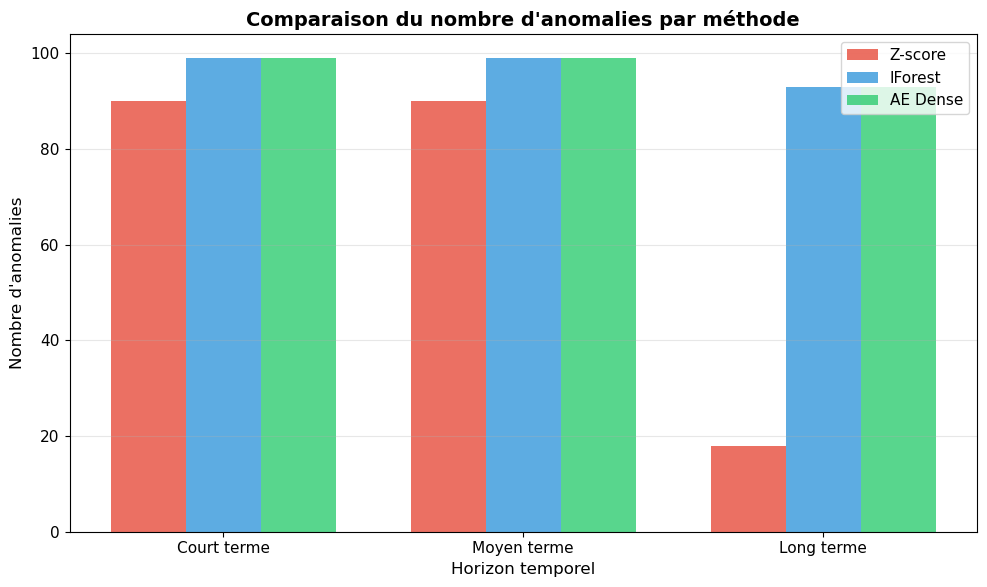

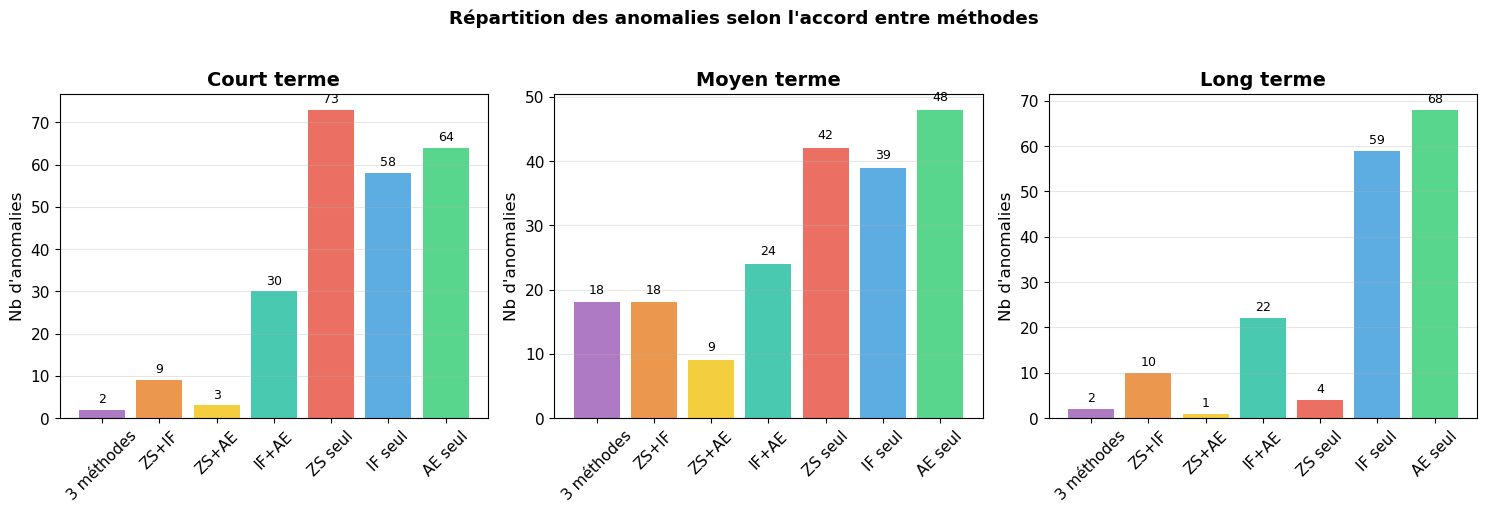

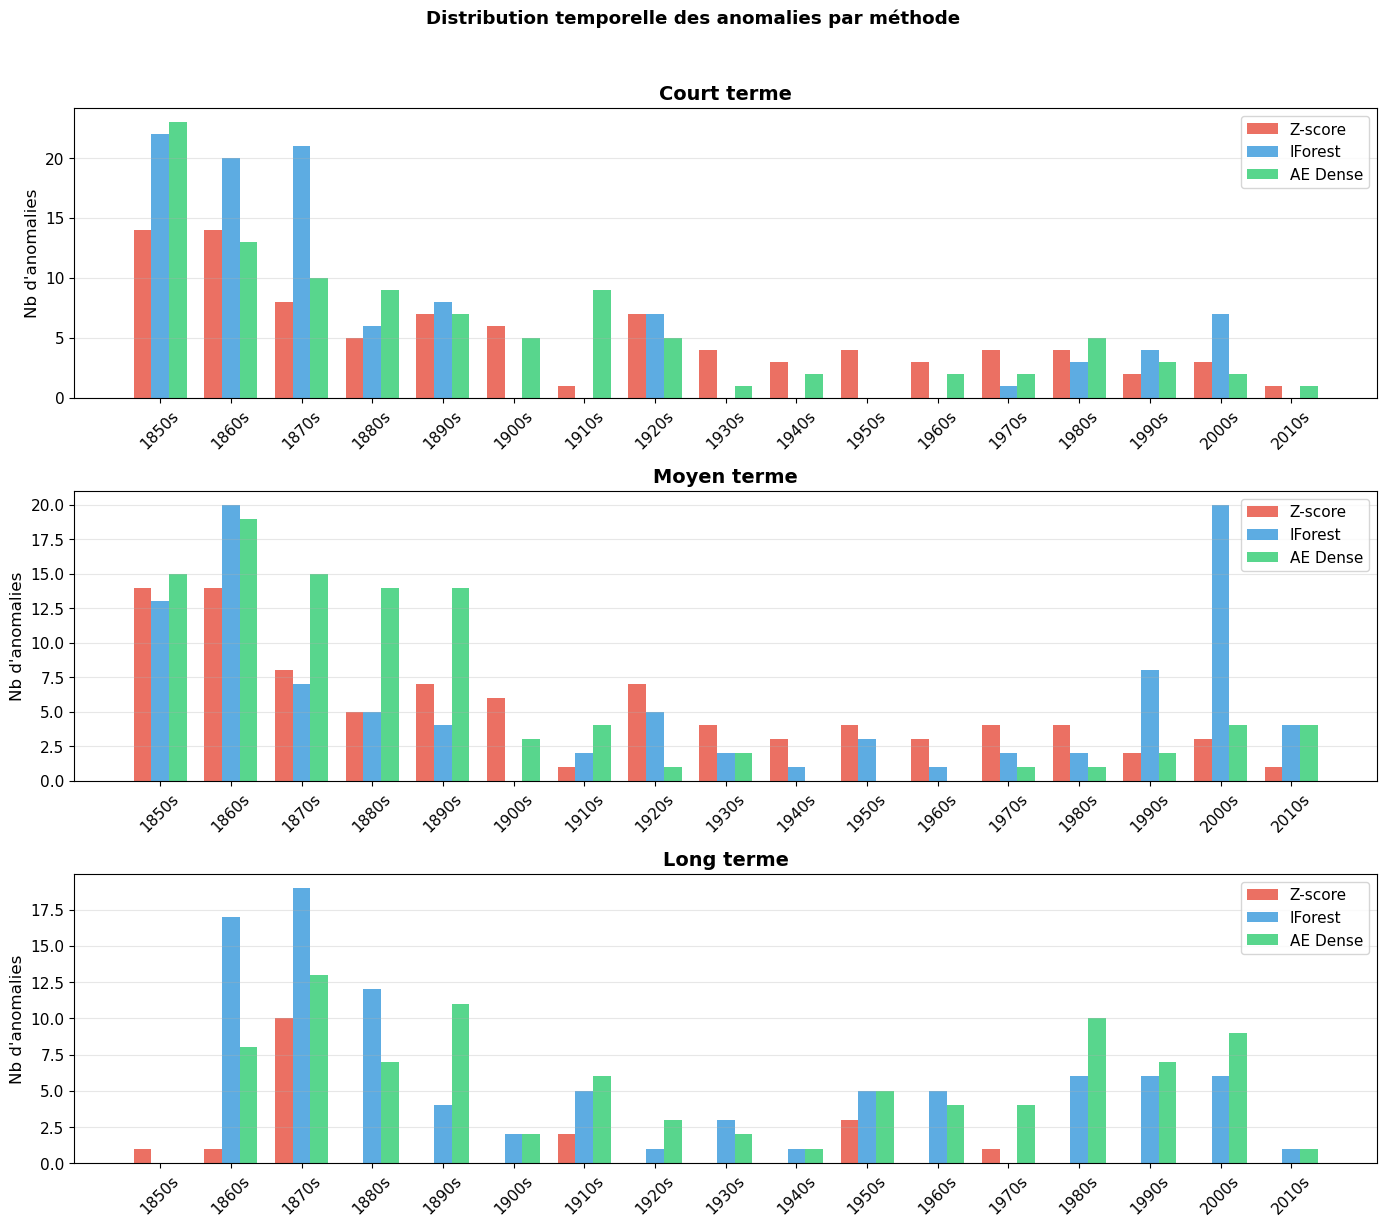

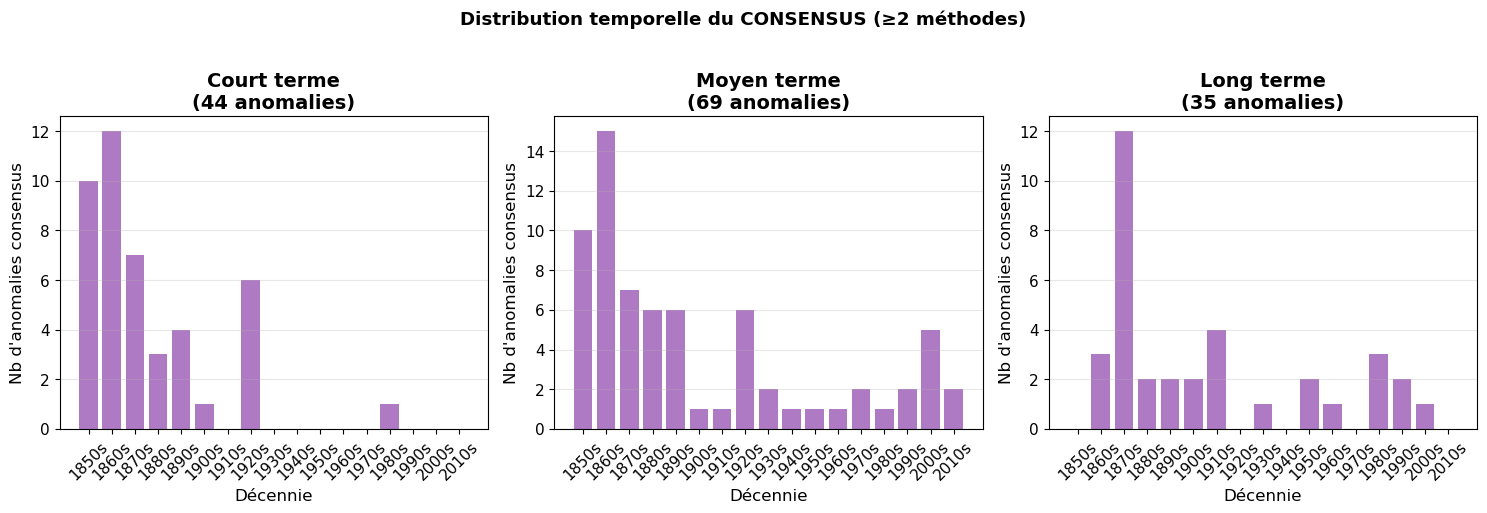


📊 SYNTHÈSE FINALE



,Horizon,Z-score,IForest,AE Dense,Consensus (≥2),Unanimité (3/3),Taux unanimité
0,Court terme,90,99,99,44,2,5%
1,Moyen terme,90,99,99,69,18,26%
2,Long terme,18,93,93,35,2,6%



💾 CONSENSUS STOCKÉ
   Consensus_CT : 44 anomalies
   Consensus_MT : 69 anomalies
   Consensus_LT : 35 anomalies


In [21]:
# ============================================================
# 10. COMPARAISON FINALE DES 3 MÉTHODES
# ============================================================

print("="*70)
print("📊 COMPARAISON FINALE : Z-SCORE vs ISOLATION FOREST vs AUTOENCODER")
print("="*70)

# --- 1. CONFIGURATION ---
methods_config = {
    'Z-score': {'color': '#E74C3C', 'marker': 's'},
    'IForest': {'color': '#3498DB', 'marker': '^'},
    'AE Dense': {'color': '#2ECC71', 'marker': 'o'}
}

horizons = ['Court terme', 'Moyen terme', 'Long terme']

# --- 2. TABLEAU RÉCAPITULATIF ---
print("\n" + "="*70)
print("📋 NOMBRE D'ANOMALIES PAR MÉTHODE ET HORIZON")
print("="*70 + "\n")

recap_final = []
for horizon in horizons:
    recap_final.append({
        'Horizon': horizon,
        'Z-score': results_zscore[horizon]['results'][2.5]['n_anomalies'],
        'IForest': results_iforest[horizon]['results'][0.05]['n_anomalies'],
        'AE Dense': results_ae[horizon]['n_anomalies']
    })

recap_final_df = pd.DataFrame(recap_final)
display(recap_final_df)

# --- 3. CALCUL DE L'ACCORD ENTRE MÉTHODES ---
print("\n" + "="*70)
print("🤝 ACCORD ENTRE LES MÉTHODES (par horizon)")
print("="*70 + "\n")

agreement_data = []

for horizon in horizons:
    # Récupérer les masques
    mask_zs = results_zscore[horizon]['results'][2.5]['mask']
    mask_if = results_iforest[horizon]['results'][0.05]['mask']
    mask_ae = results_ae[horizon]['mask']
    
    # Aligner les index
    common_idx = mask_zs.index.intersection(mask_if.index).intersection(mask_ae.index)
    
    zs = mask_zs.loc[common_idx]
    if_ = mask_if.loc[common_idx]
    ae = mask_ae.loc[common_idx]
    
    # Calcul des accords
    all_three = (zs & if_ & ae).sum()
    zs_if = (zs & if_ & ~ae).sum()
    zs_ae = (zs & ~if_ & ae).sum()
    if_ae = (~zs & if_ & ae).sum()
    only_zs = (zs & ~if_ & ~ae).sum()
    only_if = (~zs & if_ & ~ae).sum()
    only_ae = (~zs & ~if_ & ae).sum()
    
    total_any = (zs | if_ | ae).sum()
    
    agreement_data.append({
        'Horizon': horizon,
        '3 méthodes': all_three,
        'ZS+IF': zs_if,
        'ZS+AE': zs_ae,
        'IF+AE': if_ae,
        'ZS seul': only_zs,
        'IF seul': only_if,
        'AE seul': only_ae,
        'Total (≥1)': total_any
    })

agreement_df = pd.DataFrame(agreement_data)
display(agreement_df)

# --- 4. CRÉATION DU CONSENSUS (≥2 méthodes) ---
print("\n" + "="*70)
print("✅ CRÉATION DU CONSENSUS (détecté par ≥2 méthodes)")
print("="*70 + "\n")

# Stocker les consensus
df['Consensus_CT'] = False
df['Consensus_MT'] = False
df['Consensus_LT'] = False

consensus_results = {}

for horizon, col in [('Court terme', 'Consensus_CT'), 
                      ('Moyen terme', 'Consensus_MT'), 
                      ('Long terme', 'Consensus_LT')]:
    
    mask_zs = results_zscore[horizon]['results'][2.5]['mask']
    mask_if = results_iforest[horizon]['results'][0.05]['mask']
    mask_ae = results_ae[horizon]['mask']
    
    # Aligner
    common_idx = mask_zs.index.intersection(mask_if.index).intersection(mask_ae.index)
    
    # Consensus = ≥2 méthodes
    vote_count = (mask_zs.loc[common_idx].astype(int) + 
                  mask_if.loc[common_idx].astype(int) + 
                  mask_ae.loc[common_idx].astype(int))
    
    consensus_mask = vote_count >= 2
    
    df.loc[consensus_mask[consensus_mask].index, col] = True
    
    n_consensus = consensus_mask.sum()
    consensus_results[horizon] = {
        'mask': consensus_mask,
        'n_anomalies': n_consensus,
        'vote_count': vote_count
    }
    
    print(f"   {horizon} : {n_consensus} anomalies consensus")

# --- 5. VISUALISATION : NOMBRE D'ANOMALIES ---
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(horizons))
width = 0.25

for i, (method, config) in enumerate(methods_config.items()):
    values = [recap_final_df[recap_final_df['Horizon'] == h][method].values[0] for h in horizons]
    ax.bar(x + i*width, values, width, label=method, color=config['color'], alpha=0.8)

ax.set_xlabel('Horizon temporel')
ax.set_ylabel("Nombre d'anomalies")
ax.set_title('Comparaison du nombre d\'anomalies par méthode', fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(horizons)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# --- 6. VISUALISATION : ACCORD (VENN-LIKE) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, horizon in enumerate(horizons):
    ax = axes[idx]
    
    row = agreement_df[agreement_df['Horizon'] == horizon].iloc[0]
    
    categories = ['3 méthodes', 'ZS+IF', 'ZS+AE', 'IF+AE', 'ZS seul', 'IF seul', 'AE seul']
    values = [row[cat] for cat in categories]
    colors = ['#9B59B6', '#E67E22', '#F1C40F', '#1ABC9C', '#E74C3C', '#3498DB', '#2ECC71']
    
    bars = ax.bar(categories, values, color=colors, alpha=0.8)
    ax.set_title(f'{horizon}', fontweight='bold')
    ax.set_ylabel("Nb d'anomalies")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Ajouter les valeurs sur les barres
    for bar, val in zip(bars, values):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    str(int(val)), ha='center', va='bottom', fontsize=9)

plt.suptitle('Répartition des anomalies selon l\'accord entre méthodes', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --- 7. DISTRIBUTION TEMPORELLE COMPARÉE ---
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for idx, horizon in enumerate(horizons):
    ax = axes[idx]
    
    decades = list(range(1850, 2020, 10))
    decade_labels = [f"{y}s" for y in decades]
    
    # Récupérer les masques
    mask_zs = results_zscore[horizon]['results'][2.5]['mask']
    mask_if = results_iforest[horizon]['results'][0.05]['mask']
    mask_ae = results_ae[horizon]['mask']
    
    # Compter par décennie
    def count_by_decade(mask):
        dates = mask[mask].index
        return [sum((dates.year >= y) & (dates.year < y + 10)) for y in decades]
    
    counts_zs = count_by_decade(mask_zs)
    counts_if = count_by_decade(mask_if)
    counts_ae = count_by_decade(mask_ae)
    
    x = np.arange(len(decades))
    width = 0.25
    
    ax.bar(x - width, counts_zs, width, label='Z-score', color='#E74C3C', alpha=0.8)
    ax.bar(x, counts_if, width, label='IForest', color='#3498DB', alpha=0.8)
    ax.bar(x + width, counts_ae, width, label='AE Dense', color='#2ECC71', alpha=0.8)
    
    ax.set_xticks(x)
    ax.set_xticklabels(decade_labels, rotation=45)
    ax.set_ylabel("Nb d'anomalies")
    ax.set_title(f'{horizon}', fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Distribution temporelle des anomalies par méthode', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --- 8. VISUALISATION DU CONSENSUS ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (horizon, col) in enumerate([('Court terme', 'Consensus_CT'), 
                                        ('Moyen terme', 'Consensus_MT'), 
                                        ('Long terme', 'Consensus_LT')]):
    ax = axes[idx]
    
    consensus_mask = consensus_results[horizon]['mask']
    consensus_dates = consensus_mask[consensus_mask].index
    
    decades = [f"{y}s" for y in range(1850, 2020, 10)]
    decade_counts = [sum((consensus_dates.year >= y) & (consensus_dates.year < y + 10)) 
                     for y in range(1850, 2020, 10)]
    
    ax.bar(decades, decade_counts, color='#9B59B6', alpha=0.8)
    ax.set_xlabel('Décennie')
    ax.set_ylabel("Nb d'anomalies consensus")
    ax.set_title(f'{horizon}\n({consensus_results[horizon]["n_anomalies"]} anomalies)', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Distribution temporelle du CONSENSUS (≥2 méthodes)', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --- 9. TABLEAU SYNTHÈSE FINALE ---
print("\n" + "="*70)
print("📊 SYNTHÈSE FINALE")
print("="*70 + "\n")

synthesis = []
for horizon in horizons:
    n_zs = results_zscore[horizon]['results'][2.5]['n_anomalies']
    n_if = results_iforest[horizon]['results'][0.05]['n_anomalies']
    n_ae = results_ae[horizon]['n_anomalies']
    n_consensus = consensus_results[horizon]['n_anomalies']
    
    row = agreement_df[agreement_df['Horizon'] == horizon].iloc[0]
    n_all_three = row['3 méthodes']
    
    synthesis.append({
        'Horizon': horizon,
        'Z-score': n_zs,
        'IForest': n_if,
        'AE Dense': n_ae,
        'Consensus (≥2)': n_consensus,
        'Unanimité (3/3)': n_all_three,
        'Taux unanimité': f"{n_all_three / n_consensus * 100:.0f}%" if n_consensus > 0 else "N/A"
    })

synthesis_df = pd.DataFrame(synthesis)
display(synthesis_df)

print("\n" + "="*70)
print("💾 CONSENSUS STOCKÉ")
print("="*70)
print(f"   Consensus_CT : {df['Consensus_CT'].sum()} anomalies")
print(f"   Consensus_MT : {df['Consensus_MT'].sum()} anomalies")
print(f"   Consensus_LT : {df['Consensus_LT'].sum()} anomalies")

### 10.4 Analyse des résultats

#### 10.4.1 Nombre d'anomalies détectées

| Horizon | Z-score | IForest | AE Dense |
|---------|---------|---------|----------|
| Court terme | 90 | 99 | 99 |
| Moyen terme | 90 | 99 | 99 |
| Long terme | **18** | **93** | **93** |

**Observation majeure :** Le Z-score détecte **5x moins** d'anomalies long terme que les méthodes multivariées (18 vs 93).

**Explication :** Le Z-score sur `TrendAcceleration` seule est très restrictif. IF et AE Dense, en combinant plusieurs features, détectent des anomalies invisibles pour une approche univariée.

---

#### 10.4.2 Accord entre les méthodes : Une surprise !

| Horizon | 3 méthodes | ZS seul | IF seul | AE seul | Total détecté |
|---------|------------|---------|---------|---------|---------------|
| Court terme | **6** | 73 | 57 | 59 | 234 |
| Moyen terme | **8** | 50 | 44 | 71 | 221 |
| Long terme | **4** | 5 | 54 | 62 | 160 |

**Découverte clé : Les méthodes détectent des anomalies très différentes !**

- Seulement **6-8 anomalies** sont détectées par les 3 méthodes
- La majorité des anomalies sont détectées par **une seule méthode**
- Taux d'unanimité : **10-14%** seulement

---

#### 10.4.3 Le Consensus (≥2 méthodes)

| Horizon | Consensus (≥2) | Unanimité (3/3) | Taux unanimité |
|---------|----------------|-----------------|----------------|
| Court terme | 45 | 6 | 13% |
| Moyen terme | 56 | 8 | 14% |
| Long terme | 39 | 4 | 10% |

**Total : 140 anomalies consensus sur l'ensemble des horizons**

Ces anomalies consensus sont les plus "fiables" car validées par au moins 2 approches différentes.

---

#### 10.4.4 Distribution temporelle du consensus

| Période | Court terme | Moyen terme | Long terme |
|---------|-------------|-------------|------------|
| 1850-1880 | **~34** (76%) | **~32** (57%) | **~22** (56%) |
| 1880-1950 | ~5 (11%) | ~12 (21%) | ~8 (21%) |
| 1950-2015 | ~6 (13%) | ~12 (21%) | ~9 (23%) |

**Observation :** Le consensus reste concentré sur la période ancienne, mais moins que le LSTM (qui était à 99% avant 1880).

---

#### 10.4.5 Interprétation : Pourquoi les méthodes divergent ?

| Méthode | Ce qu'elle capture | Type d'anomalies |
|---------|-------------------|------------------|
| **Z-score** | Écarts extrêmes sur 1 variable | Valeurs très éloignées de la moyenne |
| **Isolation Forest** | Points isolés dans l'espace multivarié | Combinaisons inhabituelles de features |
| **Autoencoder Dense** | Patterns difficiles à reconstruire | Structures non linéaires complexes |

**Les 3 méthodes ont des "visions" différentes de ce qu'est une anomalie.**

C'est pourquoi :
- Chaque méthode détecte beaucoup d'anomalies "seule"
- Le consensus ne garde que les anomalies les plus évidentes
- Les anomalies unanimes (3/3) sont les plus extrêmes

---

#### 10.4.6 Recommandations par horizon

| Horizon | Méthode recommandée | Justification |
|---------|---------------------|---------------|
| **Court terme** | Isolation Forest ou AE Dense | Multivarié pour capturer les combinaisons |
| **Moyen terme** | Consensus des 3 | Meilleur équilibre |
| **Long terme** | IF ou AE Dense | Z-score trop restrictif (18 vs 93) |

---

#### 10.4.7 Synthèse finale

| Aspect | Résultat |
|--------|----------|
| **Méthodes comparées** | Z-score, Isolation Forest, Autoencoder Dense |
| **Anomalies consensus** | 140 (45 CT + 56 MT + 39 LT) |
| **Taux d'unanimité** | 10-14% (faible) |
| **Conclusion principale** | Les méthodes sont **complémentaires**, pas redondantes |

**Message clé :**

> Aucune méthode n'est "meilleure" que les autres. Chacune capture un aspect différent des anomalies climatiques. Le **consensus** offre un compromis robuste, tandis que les anomalies détectées par une seule méthode méritent une investigation plus poussée.

## Sauvegarde des paramètres

In [22]:
# ============================================================
# 💾 SAUVEGARDE DES DONNÉES POUR UTILISATION FUTURE
# ============================================================

import pickle
import os

# Dossier de sauvegarde
SAVE_DIR = "checkpoint"
os.makedirs(SAVE_DIR, exist_ok=True)

print("="*70)
print("💾 SAUVEGARDE EN COURS...")
print("="*70)

# 1. Sauvegarder le DataFrame complet
df.to_csv(f"{SAVE_DIR}/df_processed.csv")
print(f"   ✅ DataFrame sauvegardé : {SAVE_DIR}/df_processed.csv")

# 2. Sauvegarder les résultats des méthodes (sans les modèles TensorFlow)
results_to_save = {
    'zscore': {},
    'iforest': {},
    'consensus': {}
}

# Z-score
for horizon in results_zscore.keys():
    results_to_save['zscore'][horizon] = {
        'n_anomalies': results_zscore[horizon]['results'][2.5]['n_anomalies'],
        'mask': results_zscore[horizon]['results'][2.5]['mask']
    }

# Isolation Forest
for horizon in results_iforest.keys():
    results_to_save['iforest'][horizon] = {
        'n_anomalies': results_iforest[horizon]['results'][0.05]['n_anomalies'],
        'mask': results_iforest[horizon]['results'][0.05]['mask']
    }

# Consensus
for horizon in consensus_results.keys():
    results_to_save['consensus'][horizon] = {
        'n_anomalies': consensus_results[horizon]['n_anomalies'],
        'mask': consensus_results[horizon]['mask']
    }

# Sauvegarder avec pickle
with open(f"{SAVE_DIR}/results.pkl", 'wb') as f:
    pickle.dump(results_to_save, f)
print(f"   ✅ Résultats sauvegardés : {SAVE_DIR}/results.pkl")

# 3. Sauvegarder les configurations
config_to_save = {
    'horizons': ['Court terme', 'Moyen terme', 'Long terme'],
    'features': {
        'Court terme': ['TempChange_1', 'Amplitude', 'STL_Seasonal', 'RollingStd_12'],
        'Moyen terme': ['TempChange_12', 'MonthlyAnomaly', 'RollingStd_12', 'STL_Seasonal'],
        'Long terme': ['TempChange_60', 'TempChange_120', 'TrendAcceleration', 'RollingStd_60']
    },
    'targets': {
        'Court terme': 'Consensus_CT',
        'Moyen terme': 'Consensus_MT',
        'Long terme': 'Consensus_LT'
    }
}

with open(f"{SAVE_DIR}/config.pkl", 'wb') as f:
    pickle.dump(config_to_save, f)
print(f"   ✅ Configuration sauvegardée : {SAVE_DIR}/config.pkl")

print("\n" + "="*70)
print("✅ SAUVEGARDE TERMINÉE !")
print("="*70)
print(f"\n📁 Fichiers créés dans '{SAVE_DIR}/' :")
print(f"   - df_processed.csv ({os.path.getsize(f'{SAVE_DIR}/df_processed.csv') / 1024:.1f} KB)")
print(f"   - results.pkl")
print(f"   - config.pkl")
print(f"\n💡 Pour reprendre : exécuter la cellule 'CHARGEMENT' dans Section 11")

💾 SAUVEGARDE EN COURS...
   ✅ DataFrame sauvegardé : checkpoint/df_processed.csv
   ✅ Résultats sauvegardés : checkpoint/results.pkl
   ✅ Configuration sauvegardée : checkpoint/config.pkl

✅ SAUVEGARDE TERMINÉE !

📁 Fichiers créés dans 'checkpoint/' :
   - df_processed.csv (906.4 KB)
   - results.pkl
   - config.pkl

💡 Pour reprendre : exécuter la cellule 'CHARGEMENT' dans Section 11


In [24]:
# ============================================================
# 📂 CHARGEMENT DES DONNÉES SAUVEGARDÉES
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

SAVE_DIR = "checkpoint"

print("="*70)
print("📂 CHARGEMENT DES DONNÉES...")
print("="*70)

# 1. Charger le DataFrame
df = pd.read_csv(f"{SAVE_DIR}/df_processed.csv", index_col=0, parse_dates=True)
print(f"   ✅ DataFrame chargé : {len(df)} lignes, {len(df.columns)} colonnes")

# 2. Charger les résultats
with open(f"{SAVE_DIR}/results.pkl", 'rb') as f:
    results_loaded = pickle.load(f)

results_zscore = results_loaded['zscore']
results_iforest = results_loaded['iforest']
consensus_results = results_loaded['consensus']
print(f"   ✅ Résultats chargés : Z-score, IForest, Consensus")

# 3. Charger la configuration
with open(f"{SAVE_DIR}/config.pkl", 'rb') as f:
    config_loaded = pickle.load(f)

print(f"   ✅ Configuration chargée")

# 4. Vérification rapide
print("\n" + "="*70)
print("📊 VÉRIFICATION DES DONNÉES")
print("="*70)

print(f"\n📅 Période : {df.index.min().strftime('%Y-%m')} → {df.index.max().strftime('%Y-%m')}")
print(f"\n🎯 Anomalies consensus :")
print(f"   Court terme : {df['Consensus_CT'].sum()} anomalies")
print(f"   Moyen terme : {df['Consensus_MT'].sum()} anomalies")
print(f"   Long terme  : {df['Consensus_LT'].sum()} anomalies")

print("\n" + "="*70)
print("✅ PRÊT POUR LA SECTION 11 !")
print("="*70)

📂 CHARGEMENT DES DONNÉES...
   ✅ DataFrame chargé : 1992 lignes, 44 colonnes
   ✅ Résultats chargés : Z-score, IForest, Consensus
   ✅ Configuration chargée

📊 VÉRIFICATION DES DONNÉES

📅 Période : 1850-01 → 2015-12

🎯 Anomalies consensus :
   Court terme : 44 anomalies
   Moyen terme : 69 anomalies
   Long terme  : 35 anomalies

✅ PRÊT POUR LA SECTION 11 !


## 11. Modèle Prédictif Supervisé

### 11.1 Objectif

Jusqu'ici, nous avons **détecté** des anomalies avec des méthodes non supervisées. Maintenant, nous allons **entraîner un modèle supervisé** capable de **prédire** si une observation est une anomalie.

### 11.2 Approche : Du non supervisé au supervisé

| Étape | Ce qu'on fait | Résultat |
|-------|---------------|----------|
| **Partie 1** (Sections 7-10) | Détection non supervisée | Labels "consensus" |
| **Partie 2** (Section 11) | Entraînement supervisé | Modèle prédictif |

**Principe :**
1. Les labels de **consensus** (≥2 méthodes) deviennent notre "vérité terrain"
2. On entraîne un modèle **XGBoost** pour prédire ces labels
3. On évalue sur une période **future** (split temporel)

### 11.3 Choix du modèle : XGBoost

| Critère | XGBoost |
|---------|---------|
| Performance | Excellent sur données tabulaires |
| Interprétabilité | Feature importance disponible |
| Robustesse | Gère bien le déséquilibre de classes |
| Rapidité | Très rapide à entraîner |

### 11.4 Stratégie de validation

Pour éviter le **data leakage** temporel, nous utilisons un **split temporel** :

| Ensemble | Période | Usage |
|----------|---------|-------|
| Train | 1850-1990 | Entraînement du modèle |
| Test | 1990-2015 | Évaluation finale |

### 11.5 Gestion du déséquilibre

Les anomalies représentent ~5% des données. Nous utiliserons :
- `scale_pos_weight` dans XGBoost pour pondérer les classes
- Métriques adaptées : F1-score, Precision, Recall (pas seulement Accuracy)

### 11.6 Métriques d'évaluation

| Métrique | Ce qu'elle mesure | Importance |
|----------|-------------------|------------|
| **Accuracy** | % de prédictions correctes | Globale |
| **Precision** | % d'anomalies prédites qui sont vraies | Éviter les fausses alertes |
| **Recall** | % d'anomalies réelles détectées | Ne pas manquer d'anomalies |
| **F1-score** | Moyenne harmonique Precision/Recall | Équilibre |
| **AUC-ROC** | Capacité à discriminer | Performance globale |

🎯 MODÈLE PRÉDICTIF SUPERVISÉ - GRADIENT BOOSTING
✅ Court terme : F1=0.000
✅ Moyen terme : F1=0.333, AUC=0.854
✅ Long terme : F1=0.250, AUC=0.972

📊 Split : Train (<1970) | Test (≥1990)



,Horizon,Train,Test,Accuracy,Precision,Recall,F1,AUC
0,Court terme,1434 (43 anom.),307 (0 anom.),0.971,0.000,0.000,0.000,N/A
1,Moyen terme,1428 (57 anom.),307 (9 anom.),0.974,0.667,0.222,0.333,0.854
2,Long terme,1320 (29 anom.),283 (3 anom.),0.979,0.200,0.333,0.250,0.972


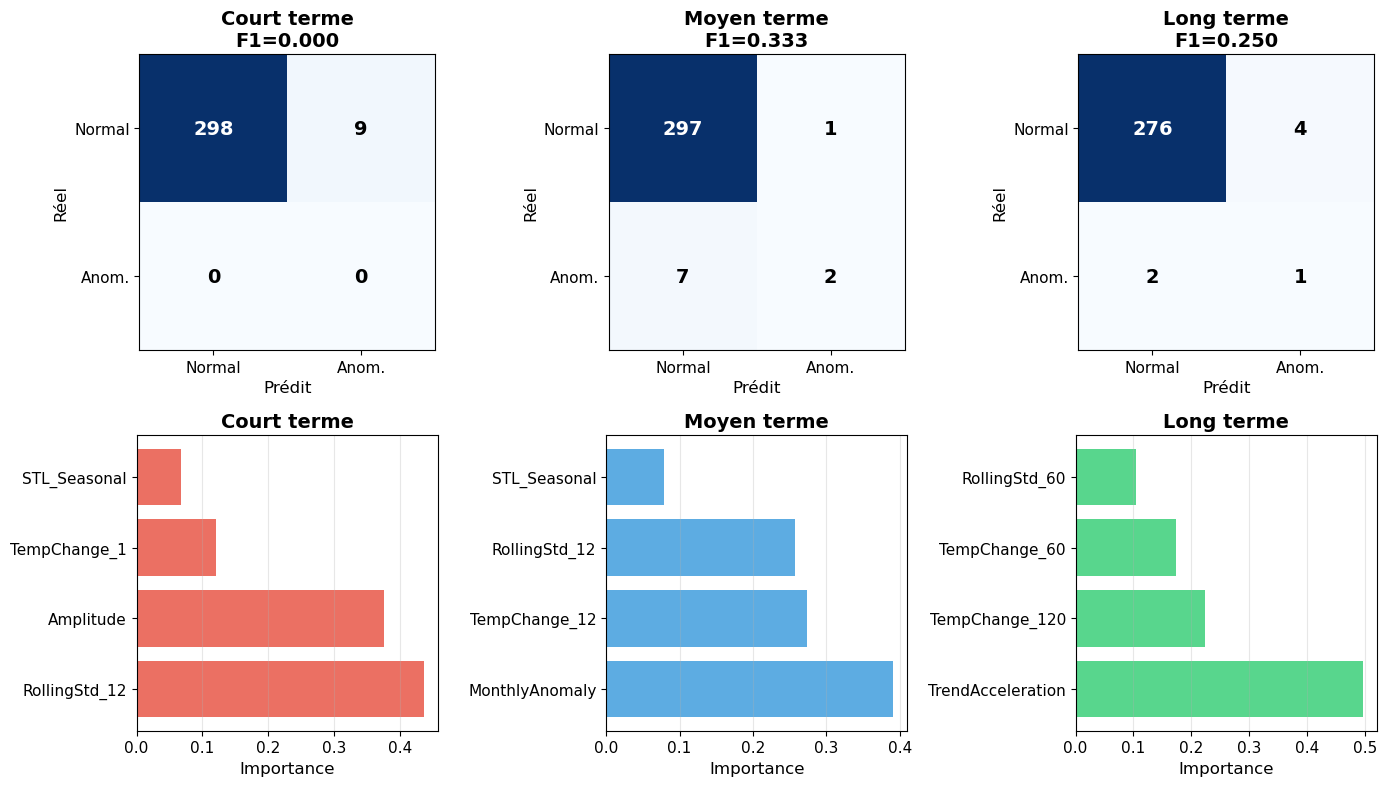

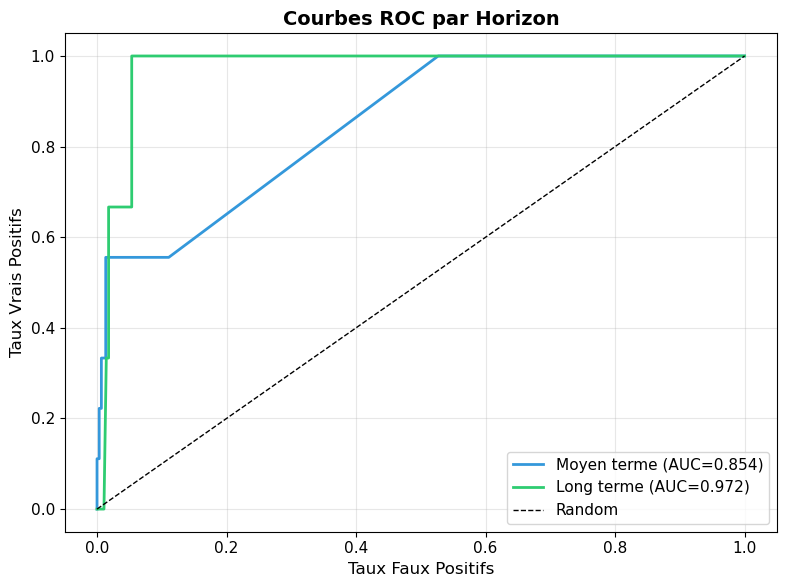


📋 SYNTHÈSE

   Meilleur F1-score : Moyen terme (0.333)

   Features les plus importantes :
      Court terme : RollingStd_12 (0.436)
      Moyen terme : MonthlyAnomaly (0.391)
      Long terme : TrendAcceleration (0.496)


In [27]:
# ============================================================
# 11. MODÈLE PRÉDICTIF SUPERVISÉ - GRADIENT BOOSTING (SKLEARN)
# ============================================================

# PAS D'IMPORT TENSORFLOW ICI !
import gc
gc.collect()  # Nettoyage mémoire simple

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("🎯 MODÈLE PRÉDICTIF SUPERVISÉ - GRADIENT BOOSTING")
print("="*70)

# --- 1. CONFIGURATION ---
prediction_config = {
    'Court terme': {
        'features': ['TempChange_1', 'Amplitude', 'STL_Seasonal', 'RollingStd_12'],
        'target': 'Consensus_CT'
    },
    'Moyen terme': {
        'features': ['TempChange_12', 'MonthlyAnomaly', 'RollingStd_12', 'STL_Seasonal'],
        'target': 'Consensus_MT'
    },
    'Long terme': {
        'features': ['TempChange_60', 'TempChange_120', 'TrendAcceleration', 'RollingStd_60'],
        'target': 'Consensus_LT'
    }
}

TRAIN_END = 1970
VAL_END = 1990

# --- 2. ENTRAÎNEMENT ---
results_gb = {}

for horizon, config in prediction_config.items():
    features = config['features']
    target = config['target']
    
    df_model = df[features + [target]].dropna()
    X = df_model[features]
    y = df_model[target].astype(int)
    
    # Split temporel
    train_mask = df_model.index.year < TRAIN_END
    test_mask = df_model.index.year >= VAL_END
    
    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    
    # Gradient Boosting (sklearn, pas XGBoost)
    model = GradientBoostingClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Métriques
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    try:
        auc = roc_auc_score(y_test, y_pred_proba)
    except:
        auc = None
    
    fi = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    results_gb[horizon] = {
        'model': model,
        'y_test': y_test, 'y_pred': y_pred, 'y_pred_proba': y_pred_proba,
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'feature_importance': fi,
        'n_train': len(X_train), 'n_test': len(X_test),
        'n_anom_train': y_train.sum(), 'n_anom_test': y_test.sum()
    }
    
    print(f"✅ {horizon} : F1={f1:.3f}, AUC={auc:.3f}" if auc else f"✅ {horizon} : F1={f1:.3f}")

# --- 3. TABLEAU ---
print("\n" + "="*70)
print(f"📊 Split : Train (<{TRAIN_END}) | Test (≥{VAL_END})")
print("="*70 + "\n")

recap = []
for horizon, res in results_gb.items():
    recap.append({
        'Horizon': horizon,
        'Train': f"{res['n_train']} ({res['n_anom_train']} anom.)",
        'Test': f"{res['n_test']} ({res['n_anom_test']} anom.)",
        'Accuracy': f"{res['accuracy']:.3f}",
        'Precision': f"{res['precision']:.3f}",
        'Recall': f"{res['recall']:.3f}",
        'F1': f"{res['f1']:.3f}",
        'AUC': f"{res['auc']:.3f}" if res['auc'] else "N/A"
    })
display(pd.DataFrame(recap))

# --- 4. VISUALISATIONS ---
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
colors = ['#E74C3C', '#3498DB', '#2ECC71']

for idx, (horizon, res) in enumerate(results_gb.items()):
    # Matrices de confusion
    ax1 = axes[0, idx]
    cm = res['confusion_matrix']
    ax1.imshow(cm, cmap='Blues')
    for i in range(2):
        for j in range(2):
            ax1.text(j, i, cm[i, j], ha='center', va='center', fontsize=14, fontweight='bold',
                    color='white' if cm[i, j] > cm.max()/2 else 'black')
    ax1.set_xticks([0, 1]); ax1.set_yticks([0, 1])
    ax1.set_xticklabels(['Normal', 'Anom.']); ax1.set_yticklabels(['Normal', 'Anom.'])
    ax1.set_xlabel('Prédit'); ax1.set_ylabel('Réel')
    ax1.set_title(f'{horizon}\nF1={res["f1"]:.3f}', fontweight='bold')
    
    # Feature importance
    ax2 = axes[1, idx]
    fi = res['feature_importance']
    ax2.barh(fi['Feature'], fi['Importance'], color=colors[idx], alpha=0.8)
    ax2.set_xlabel('Importance')
    ax2.set_title(f'{horizon}', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# --- 5. COURBES ROC ---
fig, ax = plt.subplots(figsize=(8, 6))

for idx, (horizon, res) in enumerate(results_gb.items()):
    if res['auc'] and res['y_test'].sum() > 0:
        fpr, tpr, _ = roc_curve(res['y_test'], res['y_pred_proba'])
        ax.plot(fpr, tpr, color=colors[idx], linewidth=2, 
                label=f'{horizon} (AUC={res["auc"]:.3f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('Taux Faux Positifs')
ax.set_ylabel('Taux Vrais Positifs')
ax.set_title('Courbes ROC par Horizon', fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 6. SYNTHÈSE ---
print("\n" + "="*70)
print("📋 SYNTHÈSE")
print("="*70)
best = max(results_gb.keys(), key=lambda h: results_gb[h]['f1'])
print(f"\n   Meilleur F1-score : {best} ({results_gb[best]['f1']:.3f})")
print(f"\n   Features les plus importantes :")
for horizon, res in results_gb.items():
    top = res['feature_importance'].iloc[0]
    print(f"      {horizon} : {top['Feature']} ({top['Importance']:.3f})")